<strong>UNIVERSIDADE DE SÃO PAULO (USP) </strong>\
<strong>Disciplina</strong>: Redes Complexas (SME0130) \
<strong>Docente</strong>: Francisco Aparecido Rodrigues \
<strong>Discentes</strong>: 

* Carlos Filipe de Castro Lemos (12542630)
* João Gabriel Sasseron Roberto Amorin (12542564)

# Análise de Sentimento em Redes Sociais Complexas

Nos dias de hoje, as redes sociais como o Facebook, Instagram e X (antigo Twitter) se estabeleceram como um componente vital da interação humana e da disseminação de informações. Com milhões ou bilhões de usuários ativos mensalmente, essas plataformas são essenciais para a conectividade global e para a compreensão das dinâmicas sociais contemporâneas. Nesse contexto, a importância delas vai além do número de usuários, pois servem como um ambiente prolífico para a propagação de sentimentos individuais ou coletivos. 

Com efeito, a análise de sentimentos é uma ferramenta fundamental da computação moderna e serve para interpretar e compreender a resposta emocional das pessoas às questões atuais e aos eventos mundiais. Aliás, é possível processar milhões de tweets diariamente, classificando-os em sentimentos positivos, negativos ou neutros, o que pode oferecer um retrato do humor geral da população no período de tempo considerado.

Além disso, o uso de técnicas avançadas de processamento de dados tornou-se prevalente na análise de redes sociais. Por exemplo, podemos utilizar as redes complexas para modelar as mensagens na forma de grafos (utilizando as palavras como nós e a sequência da escrita como conexões entre elas). Assim, utilizando medidas de centralidade, podemos extrair características de relevância, como identificar quais palavras são mais importantes para a formação de sentido da mensagem. A partir dessas informações, podemos extrair sentimentos prevalentes das mensagens individualmente consideradas.

Além disso, se utilizarmos o conteúdo da mensagem (_replies_ ou _hashtags_), podemos criar redes complexas que representam o fluxo de informação em rede. Isto é, se utilizarmos os _replies_ de uma mensagem, verificaresmos que um determinado usuário A envia uma mensagem ao destinatário B. Assim, teremos dois nós (A e B) e uma aresta de conexão (A-B). No entanto, se analisarmos todas as mensagens de A e de B, poderemos traçar as conexões entre esses dois usuários e seus tantos outros destinatários. Ademais, caso replicarmos o mesmo raciocínio de forma recursiva, poderemos criar um grafo que representa o fluxo de informação da rede. Nesse cenário, é possível utilizar métricas de centralidade ou técnicas de identificação de comunidades para verificar quais são as pessoas de mais influência ou quais são os nichos de comunicação existentes dentro da plataforma. 

Consequentemente, o uso de redes complexas é de grande valia na análise de sentimentos individuais ou coletivos, sendo certo que isso é relevante na medida em que permite identificar padrões comportamentais e prever tendências emergentes (modificação de comportamento social ou crises iminentes), os quais podem orientar políticas públicas ou estratégias empresariais. Concomitantemente, a extração de tópicos a partir dos dados coletados permite entender quais assuntos são mais discutidos, oferecendo insights valiosos para jornalistas, pesquisadores e tomadores de decisão.

Assim, as redes sociais não apenas facilitam a comunicação global instantânea, mas também fornecem um vasto campo de dados para análise e interpretação. Combinando algoritmos clássicos de análise de sentimentos com técnicas avançadas de processamento de dados, as plataformas como o X (antigo Twitter) se tornam poderosas ferramentas para compreender a dinâmica social contemporânea e antecipar mudanças futuras.

## Dataset

Neste projeto, utilizamos uma base de dados intitulada "Sentiment 140 Dataset", cujo arquivo de dados foi obtido na plataforma do Kaggle (_training.1600000.preprocessed.noemoticon.csv_). Esses dados representam as postagens de usuários do antigo Twitter, sendo certo que, à época, foi utilizada a Twitter API para coletar os dados. Nesse contexto, não houve direcionamento de pesquisa (NO_QUERY) e foram coletados 1.600.000 (um milhão e seiscentos mil) tweets no período de 17 de abril de 2009 (sexta-feira) até 27 de maio de 2009 (quarta-feira). 

Nesse contexto, é relevante esclarecer que os tweets foram anotados com sentimentos (0 = sentimento negativo, 2 = neutro e 4 = sentimento positivo), porém foram previamente selecionados apenas os sentimentos positivos (800.000) e negativos (800.000). Além dessas informações, a base de dados era composta dos seguintes dados:

* **_id do tweet_**: consistia em um número, como, por exemplo, 2087.
* **_data de publicação_**: identificação da data de publicação, no seguinte formato: Sat May 16 23:58:44 UTC 2009.
* **_Flag de pesquisa_**: texto usado para pesquisa ("politics") ou NO_QUERY para indicar que não houve utilização de flag.
* **_User_**: nome do usuário que realizou a publicação do twiiter, tal como robotckilldozr.
* **_text_**: texto real da publicação.

## Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import spacy
import math
import random
import re
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import community as community_louvain
import warnings

from collections import Counter
from string import punctuation
from unicodedata import normalize
from nltk.corpus import stopwords
from spacy.lang.pt.stop_words import STOP_WORDS
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from networkx.algorithms.community import girvan_newman, greedy_modularity_communities

# Desligando warnings para melhor experiência
warnings.filterwarnings("ignore")

## Funções de Apoio

In [2]:
# Carregamento do modelo de dados
nlp = spacy.load("en_core_web_lg")

In [3]:
def graph_calculate_measures(G, printing = False):
    
    def degree_distribution(G):
        vk = dict(G.degree())
        vk = list(vk.values())
        vk = np.array(vk)
        maxk = np.max(vk)
        mink = np.min(vk)
        kvalues= np.arange(0,maxk+1) # possible values of k
        Pk = np.zeros(maxk+1) # P(k)
        for k in vk:
            Pk[k] = Pk[k] + 1
        Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
        return kvalues,Pk
    
    def momment_of_degree_distribution(G,m):
        M = 0
        N = len(G)
        for i in G.nodes:
            M = M + G.degree(i)**m
        M = M/N
        return M

    def shannon_entropy(G):
        k,Pk = degree_distribution(G)
        H = 0
        for p in Pk:
            if(p > 0):
                H = H - p*math.log(p, 2)
        return H
    
    # Número de Vértices
    nN = G.number_of_nodes()                    
    if printing: print('\tNumber of nodes: \t\t', np.round(nN,3))
    
    # Número de Arestas
    nE = G.number_of_edges()                    
    if printing: print('\tNumber of edges: \t\t', np.round(nE,3))
    
    # Primeiro momento
    k1 = momment_of_degree_distribution(G,1)    
    if printing: print('\t1º Momentum: \t\t\t', np.round(k1,3))
    
    # Segundo momento
    k2 = momment_of_degree_distribution(G,2)    
    if printing: print('\t2º Momentum: \t\t\t', np.round(k2,3))
    
    # Variância
    variance = k2 - k1**2                       
    if printing: print('\tVariância Momentum: \t\t', np.round(variance,3))
    
    # Average Clustering
    av_cl = nx.average_clustering(G)
    if printing: print('\tAverage Clustering: \t\t', np.round(av_cl,3))
    
    # Entropia de Shannon
    sh_ent = shannon_entropy(G)
    if printing: print('\tShannon Entropy: \t\t', np.round(sh_ent,3))
    
    # Transitivitidade: Quantidade de Triângulos de um Grafo
    trans = nx.transitivity(G)                      
    if printing: print('\tTransitivity: \t\t\t', np.round(trans,3))

    # Diâmetro
    diameter = nx.diameter(G)                   
    if printing: print('\tDiameter: \t\t\t', np.round(diameter,3))

    # Eficiência Global da Informação (Eficiência do Grafo)
    gl_ef = nx.global_efficiency(G)             
    if printing: print('\tGlobal Efficiency: \t\t', np.round(gl_ef,3))
    
    # Eficiência Local da Informação 
    lc_ef = nx.local_efficiency(G)              
    if printing:print('\tLocal Efficiency: \t\t', np.round(lc_ef,3))
    
    # Average Shortest Path Lenght
    l = nx.average_shortest_path_length(G)      
    if printing: print('\tAverage Shortest Path Lenght: \t', np.round(l,3))
    
    # Grau de Assortatividade
    r = nx.degree_assortativity_coefficient(G)  
    if printing: print('\tAssortativity Coefficient: \t', np.round(r,3))


    ################## Medidas de centralidade ####################################
    # Grau Médio
    g = np.mean(list(dict(G.degree()).values()))
    if printing: print('\tMean Degree: \t\t\t', np.round(g,3))
    
    # Média Closeness Centrality
    cl_cent = np.mean(list(nx.closeness_centrality(G).values())) 
    if printing: print('\tCloseness Centrality: \t\t', np.round(cl_cent,3))
    
    # Média Betweenness Centrality
    bet_cent = np.mean(list(dict(nx.betweenness_centrality(G)).values())) 
    if printing: print('\tBetwenees Centrality: \t\t', np.round(bet_cent,3))

    # Average Eigenvector Centrality
    eig_value = np.mean(list(dict(nx.eigenvector_centrality(G, max_iter = 1000)).values()))
    if printing: print('\tAverage Eigenvector Centrality: ', np.round(eig_value,3))

    # Page Rank
    page_rank = np.mean(list(dict(nx.pagerank(G, alpha=0.85, max_iter=1000, weight='weight')).values()))
    if printing: print('\tPage rank: \t\t\t', np.round(page_rank,3))

    return nN, nE, k1, k2, variance, av_cl, sh_ent,trans, diameter, gl_ef, lc_ef,l, g, cl_cent, bet_cent, eig_value

In [4]:
def graph_identify_keywords(G, number = 10, printing=False):
    
    degree_scores = nx.degree_centrality(G)
    sorted_degree = sorted(degree_scores, key=degree_scores.get, reverse=True)[:number]
    if printing: print('\tDegree Centrality:\t', sorted_degree)

    pagerank_scores = nx.pagerank(G)
    sorted_pagerank = sorted(pagerank_scores, key=pagerank_scores.get, reverse=True)[:number]
    if printing: print('\tPageRank Centrality:\t',sorted_pagerank)
    
    betweenness_scores = nx.betweenness_centrality(G)
    sorted_betweenness = sorted(betweenness_scores, key=betweenness_scores.get, reverse=True)[:number]
    if printing: print('\tBetwenees Centrality:\t', sorted_betweenness)
    
    closeness_scores = nx.closeness_centrality(G)
    sorted_closeness = sorted(closeness_scores, key=closeness_scores.get, reverse=True)[:number]
    if printing: print('\tCloseness Centrality:\t', sorted_closeness)
    
    eigenvector_scores = nx.eigenvector_centrality(G, max_iter=1000)
    sorted_eigenvector = sorted(eigenvector_scores, key=eigenvector_scores.get, reverse=True)[:number]
    if printing: print('\tEigenvector Centrality:\t', sorted_eigenvector)

    return sorted_degree, sorted_pagerank, sorted_betweenness, sorted_closeness, sorted_eigenvector

In [5]:
def preprocessing_text(text):  

    # Retira toda acentuação, cedilhas e normaliza em minúsculas
    text = normalize('NFKD', text).encode('ASCII','ignore').decode('ASCII').lower()

    # Retira todos os dígitos
    text = re.sub('\d+', "", text)
    
    # Retira toda pontuação com variações acrescentadas
    to_get_off = ['¹','²', '³', 'º', 'ª', '==', ',', ':', '\"', '\'']
    to_get_off.extend([*punctuation])
    text = "".join([char if char not in to_get_off else ' ' for char in text])
    
    # Remove espaços sobrando
    text = re.sub('\s+', " ", text).split(" ")
            
    return text

In [6]:
def graph_build(palavras):

    # Criar grafo
    G = nx.Graph()

    # Adicionar nós ao grafo na ordem em que aparecem na lista
    for i in range(len(palavras) - 1):
        if not G.has_node(palavras[i]):
            G.add_node(palavras[i])
        if not G.has_node(palavras[i + 1]):
            G.add_node(palavras[i + 1])
    
    # Adicionar arestas ao grafo
    for i in range(len(palavras) - 1):
        G.add_edge(palavras[i], palavras[i + 1])

    # Tranformação para Grafo Não-Direcionado
    G = G.to_undirected()

    # Removendo Self Loops
    G.remove_edges_from(nx.selfloop_edges(G))

    # Ordenando componentes por ordem de tamanho, selecionando o maior
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(Gcc[0])
    
    return G

In [7]:
def sentiment_vader(x: str):
    """A ideia do Vader é passar a frase inteira, incluindo emoticon e pontuação."""
    text = SentimentIntensityAnalyzer().polarity_scores(x)
    return text['compound']

In [8]:
def sentiment_textblob(x: str):
    """A ideia do TextBlob é analisar uma sentença inteira. Analisando as diferenças,
    são mínimas entre o texto com pontuação e sem pontuação. O seu intervalo é equivalente
    ao do Vader, variando de [-1,1]."""
    sentiment = SentimentIntensityAnalyzer()
    return TextBlob(x).sentiment.polarity

In [9]:
def graph_x_word_most_frequent(x: int, lista: list, title: str):
    # Ordenar as palavras por frequência (da mais alta para a mais baixa)
    mf = Counter(lista).most_common(x)

    # Extrair palavras e frequências para o gráfico
    ws = [w for w, f in mf]
    fs = [f for w, f in mf]

    # Configurações estéticas usando Seaborn
    plt.figure(figsize=(14, 8))
    sns.barplot(x=ws, y=fs, palette='rocket', hue=ws)
    plt.xlabel('Palavra')
    plt.ylabel('Frequência')
    plt.title(f'50 Palavras Mais Frequentes {" - "+title if title else ""}', fontsize=18, fontweight='bold')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return mf

In [10]:
def plot_communities(gr, alg, name):
    '''
    Faz o plot do grafo colorindo cada nó com uma cor referente a sua comunidade.

    Args:
        gr (graph): grafo.
        alg (dict): dicionário com cada nó e sua comunidade.
        name (str): string com o nome do algoritmo.
    '''
    unique_communities = set(alg.values())
    color_map = plt.get_cmap('viridis', len(unique_communities))
    colors = [color_map(alg[node]) for node in gr.nodes()]

    # Plot do grafo
    pos = nx.spring_layout(gr)  
    plt.figure(figsize=(12, 12))

    # Desenho dos nós
    nx.draw_networkx_nodes(gr, pos, node_color=colors, node_size=50, cmap=color_map)
    
    # Desenho das arestas
    nx.draw_networkx_edges(gr, pos, alpha=0.5)

    plt.title(f'Comunidades detectadas pelo método {name}', fontsize=18, fontweight='bold')
    plt.show()

In [11]:
def graph_communities_frequency(df: pd.DataFrame, col: str):
    plt.figure(figsize=(10, 6))
    color_map = plt.get_cmap('viridis', (len(set(df[col]))))
    sns.countplot(x=col, data=df, orient='h', hue=col)
    plt.title(f'Frequência das Mensagens nas Comunidades - Algoritmo: {col}', fontsize=18, fontweight='bold')
    plt.xlabel('Comunidade')
    plt.ylabel('Frequência')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [12]:
def cloud(text, mw = 200):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=mw).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [13]:
def cloud_user(df_cloud, keyword, user):
    '''
    Dado um usuário, cria sua nuvem de palavras e compara a similaridade dos textos entre os diferentes métodos selecionados.

    Args:
        keyword (str): seleção da coluna do DataFrame contendo a lista de palavras chaves.
        user (str): nome do usuário.
    '''
    communities_types = ['louvain', 'girvan_newman', 'greedy_modularity']
    communities_text = []
    
    user_community = df_cloud[df_cloud['user'] == user]
    
    # Percorre as comunidades e para cada comunidade concatena os textos de todos os seus usuários para
    # geração de uma nuvem de palavras. 
    for community_type in communities_types:
        community = user_community[community_type].iloc[0]
        
        # Seleção de usuários de uma mesma comunidade 
        df = df_cloud[df_cloud[community_type] == community].copy()

        # Texto concatenado
        text = ' '.join(df[keyword].astype(str))
        
        communities_text.append(text)
        
    # Plotagem das nuvens de palavras lado a lado
    fig, axes = plt.subplots(1, 3, figsize=(24, 18))
    for i, text in enumerate(communities_text):
        wordcloud = WordCloud(width=400, height=300, background_color='white').generate(text)
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(f'Comunidade ({communities_types[i]}) #{user_community[communities_types[i]].iloc[0]}')
        
    plt.show()
    
    # Por meio atulização da vetorização de texto, fazemos a similaridade entre os textos.
    print(f'==== SIMILARITY ')
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(communities_text)
    similarity_matrix = cosine_similarity(tfidf_matrix)
    
    for i in range(len(communities_types)):
        for j in range(i):
            print(f'{communities_types[i]} vs {communities_types[j]}: {similarity_matrix[i, j]}')

## Análise Exploratória dos Dados e Coleta de Informações

Em um primeiro momento, iremos realizar uma análise dos dados do dataset para entendermos como eles estão formatados, bem como qual é a forma como estão distribuídos.

In [14]:
# Carregamento dos dados
nomes = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv('../data/training.1600000.processed.noemoticon.csv',header=None, names=nomes,encoding='latin1')

In [15]:
# Identificação dos limites das datas dos tweets
df['date'].min(), df['date'].max()

('Fri Apr 17 20:30:31 PDT 2009', 'Wed May 27 07:27:38 PDT 2009')

In [16]:
# Contagem dos labels de classificação
df.groupby('target')['target'].count()

target
0    800000
4    800000
Name: target, dtype: int64

In [17]:
df.head(5)

target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

In [18]:
df.tail(5)

target         ids                          date      flag  \
1599995       4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996       4  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997       4  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998       4  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999       4  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                    user                                               text  
1599995  AmandaMarie1028  Just woke up. Having no school is the best fee...  
1599996      TheWDBoards  TheWDB.com - Very cool to hear old Walt interv...  
1599997           bpbabe  Are you ready for your MoJo Makeover? Ask me f...  
1599998     tinydiamondz  Happy 38th Birthday to my boo of alll time!!! ...  
1599999   RyanTrevMorris  happy #charitytuesday @theNSPCC @SparksCharity...

In [19]:
for column in df.columns:
    unique_values = df[column].unique()
    num_unique = len(unique_values)
    random_elements = random.sample(list(unique_values), min(3, num_unique))
    
    print(f"Coluna '{column}':")
    print(f"   Quantidade de elementos únicos: {num_unique}")
    print(f"   Exemplos aleatórios: {random_elements}")
    print()

Coluna 'target':
   Quantidade de elementos únicos: 2
   Exemplos aleatórios: [0, 4]

Coluna 'ids':
   Quantidade de elementos únicos: 1598315
   Exemplos aleatórios: [2013955008, 1835261067, 2057992038]

Coluna 'date':
   Quantidade de elementos únicos: 774363
   Exemplos aleatórios: ['Thu Jun 18 13:19:06 PDT 2009', 'Sun May 17 04:46:28 PDT 2009', 'Sun May 17 11:32:28 PDT 2009']

Coluna 'flag':
   Quantidade de elementos únicos: 1
   Exemplos aleatórios: ['NO_QUERY']

Coluna 'user':
   Quantidade de elementos únicos: 659775
   Exemplos aleatórios: ['amystardust', 'tru24', 'ocadi']

Coluna 'text':
   Quantidade de elementos únicos: 1581466
   Exemplos aleatórios: ['@smokedrinkdrive  I really wish I could help! Its hard to get a job right now ', 'All ready to hit the park   http://twitpic.com/6bo7h', 'I want to act again... ']



Nesse contexto, verificamos que iremos analisar dados apenas com sentimentos positivos ou negativos que foram postados entre 17 de abril de 2009 (sexta-feira) até 27 de maio de 2009 (quarta-feira) e não houve direcionamento de pesquisa (um único valor em flag - NO_QUERY). Além disso, existem 18534 tweets que repetem o mesmo texto de outros tweets, bem como o número de usuários únicos é 41% (quarenta e um porcento) do total, o que sugere que existem usuários que postaram mais de uma vez.

## Montagem do Grafo da Rede Social

### Técnica da Montagem

A rede social será representada abaixo utilizando usuários como nós e os replies de suas mensagens como o elemento de conexão entre eles. Por exemplo: verificamos que o usuário 'SusanCosmos' interagiu com o usuário 'DeniseMM' da seguinte forma: 

<center>"<b>@DeniseMM</b> I know... It's an ugly thing. And, I'm seeing others getting it now too. NOT good. Thanks for sticking w/ me! " (grifos nossos)</center>

Em outras palavras, o usuário 'SusanCosmos' referenciou o usuário 'DeniseMM' por meio da utilização do @ no texto do tweet (mensagem). É exatamente essa conexão entre usuários que permite a elaboração do grafo.

In [20]:
df.loc[df['user'] == 'SusanCosmos', 'text'].iloc[0]

"@DeniseMM I know... It's an ugly thing. And, I'm seeing others getting it now too. NOT good. Thanks for sticking w/ me! "

No entanto, podemos perceber que o usuário 'SusanCosmos' não mandou mensagem apenas para o usuário 'DeniseMM', mas, sim, para um total de 224 outros usuários (considerando repetições de usuários). Aliás, em análises prévias, observamos que 'SusanCosmos' era o usuário mais conectado do grafo. Assim, seja como for, se acessarmos as mensagens desses usuários conectados com 'SusanCosmos', perceberemos que eles também tem suas conexões e, por meio delas, podemos estabelecer outras conexões. Desse modo, podemos criar um grafo com as conexões existentes entre os usuários dos 1.600.000 tweets disponíveis.

In [21]:
destinatarios = []
for text in df.loc[df['user'] == 'SusanCosmos', 'text']:
    destinatarios.extend(re.findall(r"@(\w+)", text))
print("Destinários das mensagens do usuário 'SusanCosmos': \n", destinatarios)
print("Total de destinatários: ", len(destinatarios))

Destinários das mensagens do usuário 'SusanCosmos': 
 ['DeniseMM', 'bluestreak23', 'brandisco', 'Martiword', 'jimrcummings', 'texasjackflash', 'MPMEleanor', 'jimhunt', 'brandisco', 'moble', 'billionaire5', 'dvineexpression', 'drts3biznet', 'NickDeStefano', 'DaBombChele', '007wisdom', 'LadyJudi', 'lovepeaceunity', 'SheilaUlrich', 'shannontalford', 'Jfavreau', 'MPMEleanor', 'JimSutton5', 'ptnetwork', 'tdbriz', 'TomDuong', 'cmalesic', 'silixell', 'unikeone', 'chavis_t', 'NancyEllyn', 'dudeman718', 'ViriamKaur', 'jo484bu', 'cArtPhotography', 'augnbudsmom', 'quotesource', 'firstpagepro', 'successwalls', 'allthesimple', 'VisionTwits', 'debrasteele', 'JaxLicurse', 'boomerous', 'OprahExaminer', 'NatalieNews', 'crisjobcoach', 'cmeihoong', 'Ceemb', 'iamwun', 'F_o_Lucion', 'FrankDickinson', 'CandyWWGM', 'MirrorFinish', 'BWBRadioShow', 'pryankaa', 'MRHYPERPCS', 'legator02', 'WillieCrawford', 'julieunplugged', 'CEOTransformer', 'Conniedr', 'Renee_KY', 'Moekelsak', 'Jfavreau', 'sandramariecom', 'the

### Restrições: Selfloops

Nesse contexto, é preciso tomar cuidado com algumas situações. Por exemplo, existem casos de pessoas que marcam a si próprias como destinatárias das mensagem, o que pode ser um problema para o processamento das redes complexas. No caso dos dados, verificamos que existem 1650 pessoas que mandaram mensagens a si mesmos:

In [22]:
selfloop = []
for index, row in df.iterrows():
    if row['user'] in re.findall(r"@(\w+)", row['text']): selfloop.append(row['user'])
print('Total de selfloops: ', len(selfloop))
print('Pessoas que mandaram mensagem a si próprias:\n', selfloop)

Total de selfloops:  1650
Pessoas que mandaram mensagem a si próprias:
 ['sweetlyaroundme', 'HeyChinaski', 'dysconnection', 'PixyMisa', 'robbhughes', 'simon14771482', 'Cynsational', 'DashKitten', 'k_anelundi', 'ExciteMike', 'ddrattack', 'elleanor_', 'waynelongton', 'monkey29992', 'fohlinspam', 'rockstarchick', 'Hollywood_Trey', 'NinaLaDolce', 'vyzion360', 'mattmagic', 'dosborne', 'mrbrownie', 'sheetalk', 'sheetalk', 'lookfolio', 'D0peNerd', 'JackieInChgo', 'eisen', 'tuscantom', 'rokmi3', 'fcandle', 'berryaddict', 'KT2010', 'janicellamoca', 'CDX', 'chorale', 'supraprophetic', 'Katpoynter', 'mamaAllie', 'scott420brown', 'yurple67', 'Accidentaldiva', 'DannyGirlAlways', 'ohthyme', 'coliwilso', 'ideamonk', 'wisguy', 'Courtni2', 'mcatherineblack', 'elhubcapo', 'djaggisbreezy', 'stefanvdeijk', 'andrei_bobocea', 'XBASSISTSX', 'DidierStevens', 'slooude', 'braket', 'arm_candy', 'nckwtrs', 'Shotshog', 'semipenguin', 'tmotley89', 'WWEChickJes54', 'marlenedlr', 'PhaTrak', 'nsane8', 'PitbullMomma111

Exemplo de mensagem que referencia a si próprio:

In [23]:
df.loc[df['user'] == 'robbhughes', ['user','text']]

user                                text
10311  robbhughes  @robbhughes is very bored in work 
10346  robbhughes              is very bored in work

### Restrições: Tamanho do Grafo e Recursos Computacionais

Vale acrescentar também que não iremos utilizar todas as conexões do grafo porque ele fica muito extenso. Isso iria trazer dificuldades adicionais, como tempo de processamento computacional e complicações de análise e interpretação. Por isso, optamos por utilizar apenas dados referentes às pessoas que apresentaram mais de duas conexões.

### Restrições: Grafos não Completamente Conectados

Além das outras restrições acima, pode acontecer de existir um grupo de usuários que se conectam entre si, porém não se conectam com outros grupos de usuários. Assim, podem existem subgrafos que não estejam conectados com outros subgrafos, o que gera um grafo não completamente conectado. Isso pode gerar problemas de processamento no momento de execução dos algoritmos de redes complexas. Por isso, é importante que façamos uma seleção apenas da maior rede conectada. Nesse caso, aproveitaremos o melhor contexto dos dados e poderemos aplicar corretamente os algoritmos de bibliotecas como o Networkx.

### Montagem do Grafo

Levando em consideração as definições e restrições acima, podemos criar o grafo da seguinte forma:

In [24]:
# Criando um grafo não direcionado
G = nx.Graph()

# Coletando todos os usuários do conjunto
df['user'].apply(lambda x: G.add_node(x))

# Percorrendo os tweets e criando as conexões entre usuários
for index, line in df.iterrows():
    replieds = re.findall(r"@(\w+)", df.iloc[index,5])
    # Selecionando apenas as pessoas com mais de duas conexões
    if len(replieds) > 2: 
        for replied in replieds: 
            if G.has_node(replied) and G.has_node(df.iloc[index,4]):
                G.add_edge(df.iloc[index,4], replied)

# Removendo as mensagens dos usuários que mandam mensagens a si mesmos
G.remove_edges_from(nx.selfloop_edges(G))

# Selecionando apenas o maior componente conectado
connected = nx.connected_components(G)
maior = max(connected, key=len)
G = G.subgraph(maior)

# Dados do grafo
print('Número de Nós: ', G.number_of_nodes())
print('Número de Arestas: ', G.number_of_edges())

Número de Nós:  3358
Número de Arestas:  4116


Verificação das conexões de 'SusanCosmos' (como um subgrafo do grafo completo), temos o seguinte:

Nó mais conectado: SusanCosmos
Número Total de Vizinhos: 93
Vizinhos: ['bluestreak23', 'brandisco', 'Martiword', 'MPMEleanor', 'moble', 'dvineexpression', '007wisdom', 'lovepeaceunity', 'tdbriz', 'TomDuong', 'SusanPreston', 'silixell', 'chavis_t', 'dudeman718', 'ViriamKaur', 'jo484bu', 'cArtPhotography', 'quotesource', 'firstpagepro', 'allthesimple', 'debrasteele', 'JaxLicurse', 'crisjobcoach', 'cmeihoong', 'Ceemb', 'iamwun', 'CandyWWGM', 'MirrorFinish', 'pryankaa', 'MRHYPERPCS', 'NewAgeSelfHelp', 'legator02', 'WillieCrawford', 'julieunplugged', 'CEOTransformer', 'Renee_KY', 'Moekelsak', 'sandramariecom', 'StephenGonzalez', 'BelieveAnyway', 'butterflymaven', 'LilliJ', 'JoanneRK', 'DivaChampion', 'stacykinney', 'TheTAZZone', 'abbyharenberg', 'MATT_369', 'Marge_Inovera', 'muttleylax', 'SpiritLibrary', 'ayomsb', 'heejung', 'LoriMoreno', 'americandream09', 'Djalfy', 'impollyanna', 'tomesimpson', 'tap29', 'DeAnnLR', 'ISOLABELLA', 'FitMenu', 'SandiDarwin', 'xmellyssax', 'PeaceDiva', 'writing

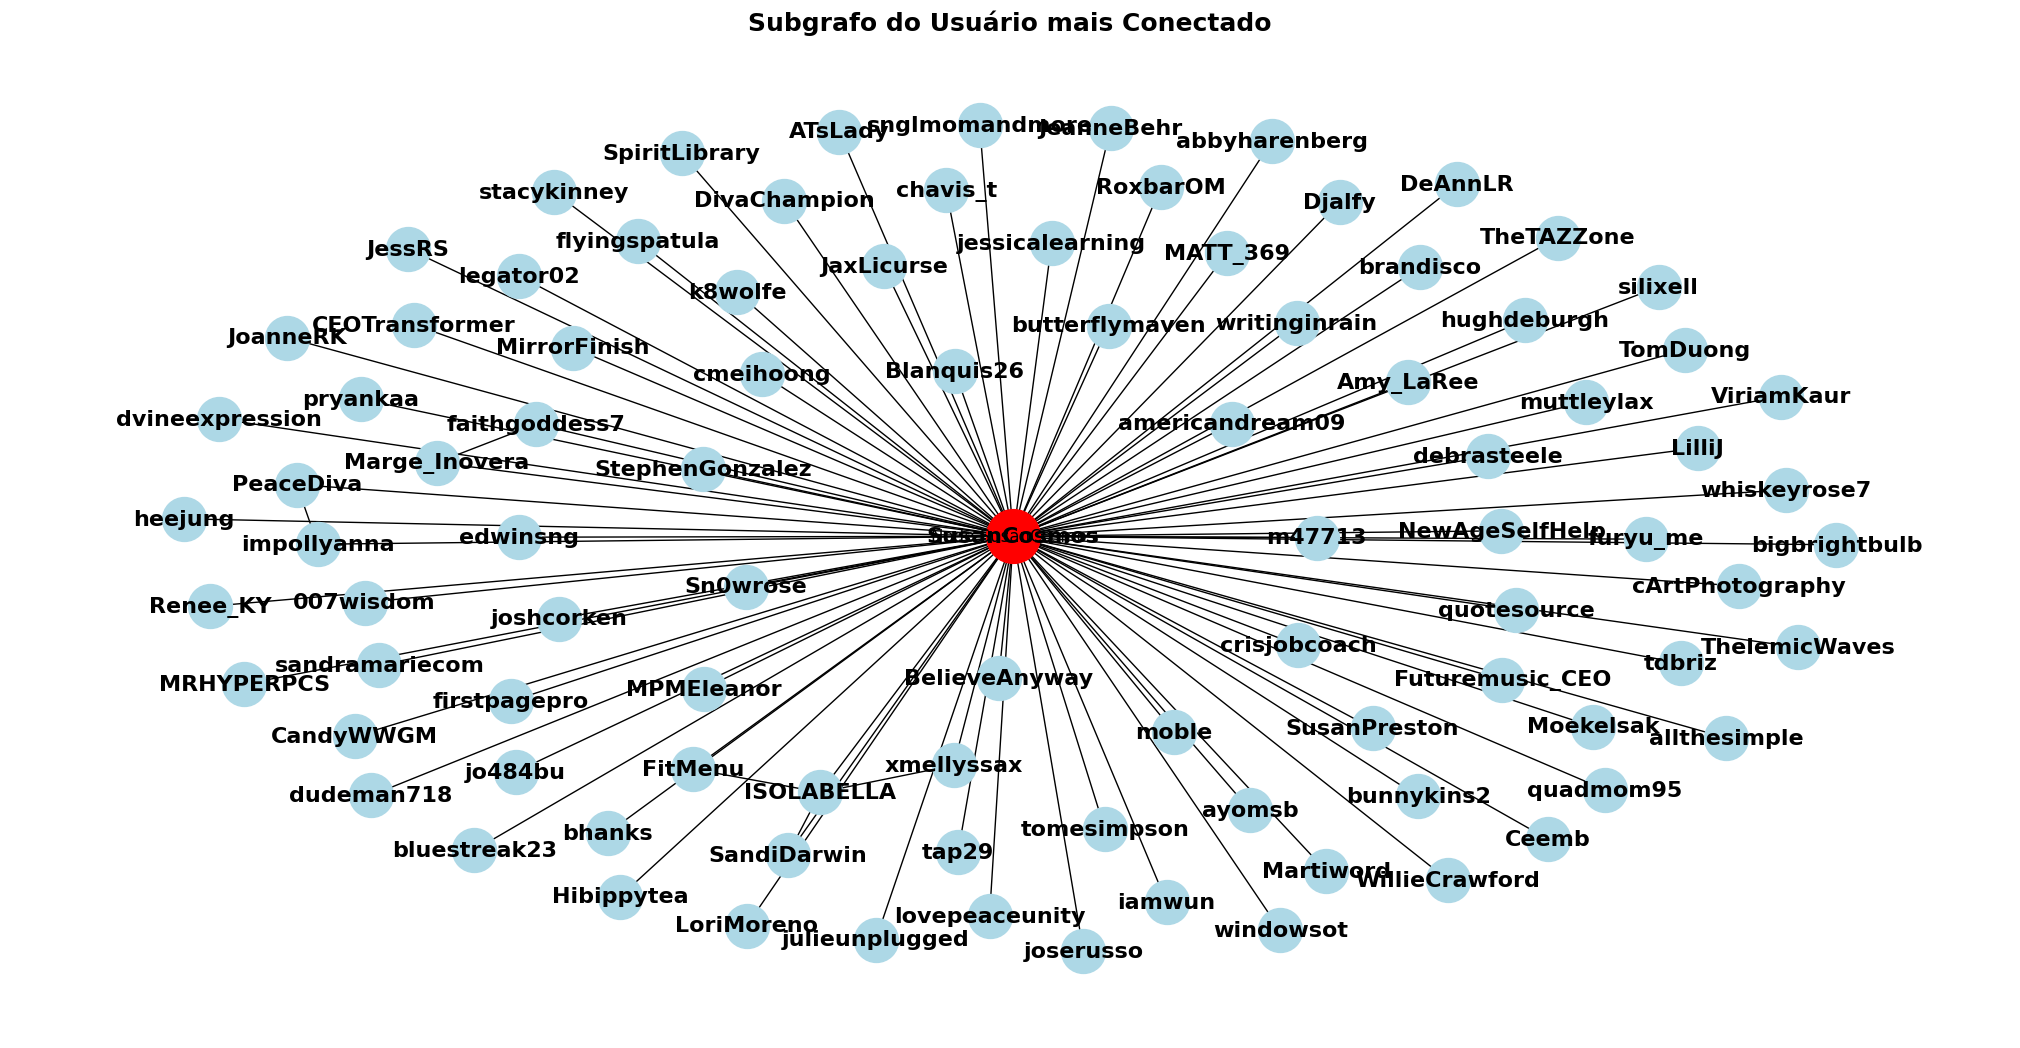

In [25]:
# Encontrar o nó com mais conexões (maior grau)
max_degree_node = max(G.nodes(), key=G.degree)

# Obter os vizinhos do nó com mais conexões
neighbors = list(G.neighbors(max_degree_node))

# Identificar o label do nó
node_label = G.nodes[max_degree_node]['label'] if 'label' in G.nodes[max_degree_node] else max_degree_node
nodes_to_plot = [max_degree_node] + neighbors

# Plotar o subgrafo do nó mais conectado
H = G.subgraph(nodes_to_plot)
plt.figure(figsize=(20, 10))

# Layout para posicionar os nós
pos = nx.spring_layout(H)  
nx.draw(H, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=16, font_color='black', font_weight='bold')

# Destacar o nó mais conectado e seus vizinhos com outra cor
nx.draw_networkx_nodes(H, pos, nodelist=[max_degree_node], node_color='red', node_size=1500)
nx.draw_networkx_nodes(H, pos, nodelist=neighbors, node_color='lightblue', node_size=1000)

# Adicionar rótulos 
nx.draw_networkx_labels(G, pos, labels={max_degree_node: f'Node {max_degree_node}'}, font_size=12, font_color='black')

print(f"Nó mais conectado: {max_degree_node}")
print(f"Número Total de Vizinhos: {len(neighbors)}")
print(f"Vizinhos: {neighbors}")

plt.title(f'Subgrafo do Usuário mais Conectado', fontsize=18, fontweight='bold')
plt.show()

Observando o grafo acima, podemos notar que, embora o usuário 'SusanCosmos' tenha referenciado o 224 usuários, percebemos que, no grafo montado, apareceram 93 usuários. Isso demonstra que o usuário mandou mais de uma mensagem a um ou mais usuários. Além disso, observando o subgrafo atentamente, é possível verificar que existem conexões entre outros usuários como 'ISOLABELLA' e 'SandiDarwin', 'FitMenu' e 'xmellyssax'. Aliás, se formos visualizar o grafo completo, teríamos a seguinte imagem:

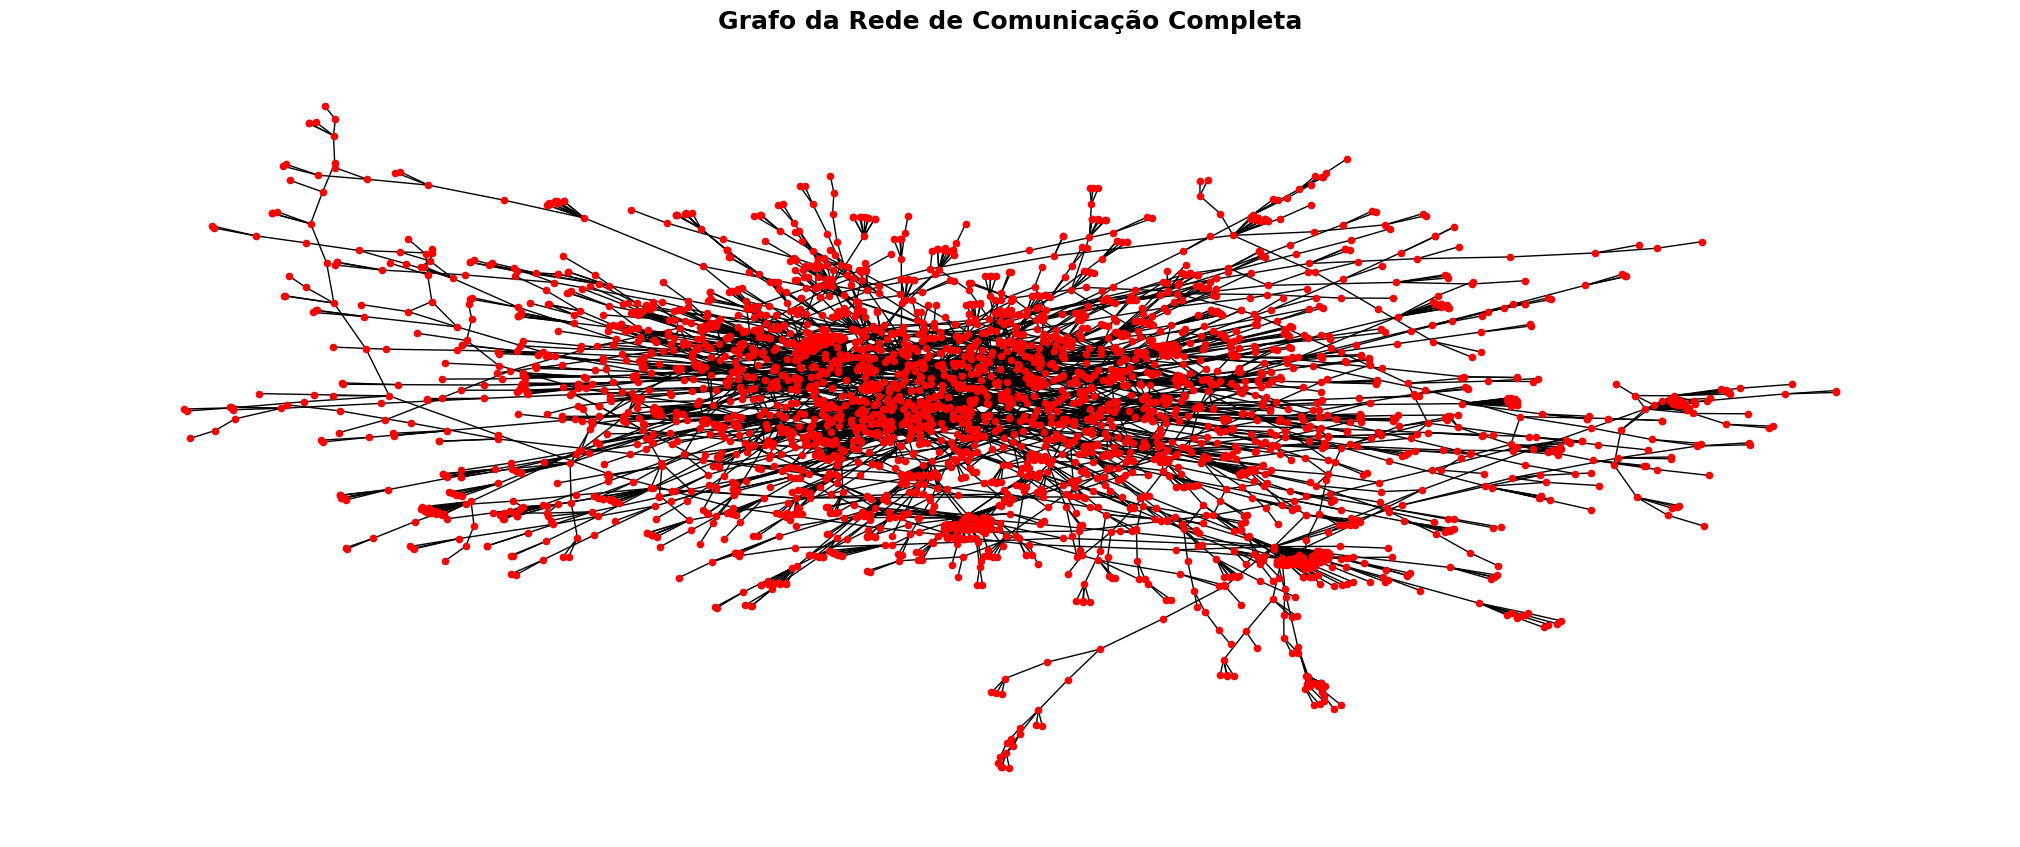

In [26]:
plt.figure(figsize=(20,8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_color='red', node_size=20, font_size=8, font_weight='bold')
plt.title(f'Grafo da Rede de Comunicação Completa', fontsize=18, fontweight='bold')
plt.show()

### Métricas do Grafo da Rede Social

Com efeito, podemos interpretar algumas medidas quantitativas do grafo.

In [27]:
# Cálculo das Medidas do Grafo
print('Medidas do Grafo:')
graph_calculate_measures(G, printing=True)
print()

Medidas do Grafo:
	Number of nodes: 		 3358
	Number of edges: 		 4116
	1º Momentum: 			 2.451
	2º Momentum: 			 21.102
	Variância Momentum: 		 15.092
	Average Clustering: 		 0.037
	Shannon Entropy: 		 2.22
	Transitivity: 			 0.026
	Diameter: 			 40
	Global Efficiency: 		 0.111
	Local Efficiency: 		 0.04
	Average Shortest Path Lenght: 	 10.673
	Assortativity Coefficient: 	 -0.131
	Mean Degree: 			 2.451
	Closeness Centrality: 		 0.098
	Betwenees Centrality: 		 0.003
	Average Eigenvector Centrality:  0.003
	Page rank: 			 0.0



A interpretação mostra que o grafo tem  3358 vértices e 4116 arestas, sendo certo que possui uma média de 2.451 graus por vértice. Aliás, existe uma grande variância no graus (15.092). Além disso, o grafo não tem tendência de formar cluster e existe pouca conexão de um nó com seus vizinhos. A informação circula com dificuldade, seja globalmente ou localmente em uma comunidade. A maior menor distância é de 40 vértices  e não há tendência de formação de comunidades. Demais características mostra pouca centralidade dos usuários.

## Identificação dos Usuários Centrais

Agora que o grafo da rede social foi montado, e conhecemos um pouco de suas medidas, passaremos a analisar outras de suas características e preparar o ambiente para análises de sentimentos mais aprofundadas. Nesse contexto, em um primeiro momento, devemos identificar quais são os usuários centrais, uma vez que eles possuem maior influência na comunicação existente na rede. Como o grafo foi montado a partir das conexões entre os usuários, a medida do grau do vértice se mostraria como uma medida adequada para identificar os usuários centrais. Por isso, quanto maior o grau de conexões, maior será a centralidade dos usuários. Porém, essa informação não é única e pode não ser realmente importante. Por isso, podemos analisar o assunto sob diferentes perspectivas. Nesse sentido, selecionaremos os 25 usuários com maior número de conexões.

In [28]:
top_degree = [x[0] for x in sorted(G.degree(), key=lambda x: x[1], reverse=True)]
top_degree = set(top_degree[:25])
top_degree

{'AlexAllTimeLow',
 'DawnofOURnight',
 'JackAllTimeLow',
 'MATT_369',
 'Netra',
 'SomersetBob',
 'StephenGonzalez',
 'SusanCosmos',
 'Trace027',
 'bacieabbracci',
 'bigenya',
 'darenBBC',
 'ddlovato',
 'dhempe',
 'epcotx',
 'esoterismo',
 'jessicastrust',
 'mayank',
 'maynaseric',
 'mcflyharry',
 'riandawson',
 'selenagomez',
 'shaaqT',
 'thenewbnb',
 'tommcfly'}

Além da quantidade de graus, iremos trabalhar com outras medidas de centralidade, tais como:

* **Degree Centrality**: a centralidade do grau de um nó é basicamente originada a partir do resultado de uma razão entre o número de arestas incidentes (conexões) dividido pela quantidade total de arestas. Vale lembrar que _degree(v)_ é o número de arestas conectadas ao nó "v" e _n_ é o número total de nós de uma rede. Fórmula:
$$C_{degree}(v) = \frac{degree(v)}{n-1}$$

* **Closeness Centrality**: esse medida fornece a noção de quão próximo um vértice está de todos os outros vértices de uma rede. Isto é, ela é basicamente calculada como o inverso da média das distâncias mais curtas entre o nós em questão e todos os outros nós da rede. Nesse contexto, _u_ e _v_ são nós da rede complexa e _n_ é o número total de nós de uma rede. Além disso, _d(u,v)_ é a distância mais curta entre os nós _u_ e _v_. Fórmula:
$$C_{closeness}(v) = \frac{n-1}{\sum_{u \neq v} d(u,v)}$$

* **Betweness Centrality**: a centralidade da intermediação mede a frequência com que um nó atua como ponte ao longo do caminho mais curto entre dois outros nós da rede. Nesse caso, $\sigma_{st}$ é o número total de caminhos mais curtos do nó _s_ ao _t_ e $\sigma_{st}(v)$ é o número de caminhos mais curtos de _s_ para _t_ que passam pelo nó _v_. Fórmula:
$$C_{betweenness}(v) = \sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}$$

* **Eigenvector Centrality**: essa medida de centralidade calcula a importância de um vértice considerando a importância dos vértices que lhes são vizinhos. Ou seja, a centralidade do autovetor atribui uma pontuação de centralidade a cada nó na rede, considerando a importância dos nós aos quais está diretamente conectado. Nesse contexto, _A_ é a matriz de adjacência da rede e $\lambda$ é o maior valor próprio (eigenvalue) da matriz A; além disso, _x_ é o vetor próprio (eigenvector) correspondente ao maior valor de $\lambda$. Fórmula: 
$$ Ax = \lambda x $$

* **Page Rank**: a centralidade do PageRank é proveniente do algoritmo que é usado para medir a importância relativa dos nós em uma rede baseada em links (como a web), onde a importância de um nó é determinada pela quantidade e qualidade dos links que apontam para ele. Nesse contexto, _PR(u)_ é o resultado PangeRank do nó _u_, _d_ é um fator de amortecimento (geralmente d=0.85), _N_ é o número total de nós da rede, $B_{u}$ é o conjunto de nós que apontam para _u_ e _L(v)_ é o número de links que saem do nó _v_. Fórmula: 
$$PR(u) = \frac{1-d}{N} + d\sum_{v in B_{u}}\frac{PR(v)}{L(v)}$$

Assim, considerando essas medidas de centralidade, podemos verificar se o grau do vértice pode ser considerada uma boa medida de centralidade. Nesse contexto, iremos selecionar apenas os 10 vértices centrais mais importantes de acordo com cada uma das medidas explicadas acima:

degree_centrality:
 Intersecção (top_degree): {'tommcfly', 'selenagomez', 'epcotx', 'SomersetBob', 'ddlovato', 'jessicastrust', 'esoterismo', 'JackAllTimeLow', 'mcflyharry', 'SusanCosmos'}
 Usuários Centrais: ['SusanCosmos', 'ddlovato', 'tommcfly', 'mcflyharry', 'selenagomez', 'epcotx', 'jessicastrust', 'SomersetBob', 'esoterismo', 'JackAllTimeLow']


closeness_centrality:
 Intersecção (top_degree): {'MATT_369', 'SusanCosmos'}
 Usuários Centrais: ['SusanCosmos', 'MATT_369', 'julieunplugged', 'faithgoddess7', 'TheTAZZone', 'PeaceDiva', 'Djalfy', 'dudeman718', 'JaxLicurse', '_DINA']


betweenness_centrality:
 Intersecção (top_degree): {'epcotx', 'ddlovato', 'MATT_369', 'SusanCosmos'}
 Usuários Centrais: ['SusanCosmos', 'Pifiz', 'MATT_369', 'akiraLOVE', 'DavidArchie', 'julieunplugged', 'ddlovato', 'Zenobie', 'epcotx', 'cescadr']


eigenvector_centrality:
 Intersecção (top_degree): {'tommcfly', 'mcflyharry'}
 Usuários Centrais: ['tommcfly', 'mcflyharry', 'keren4562', 'steph_davies', 'WalkI

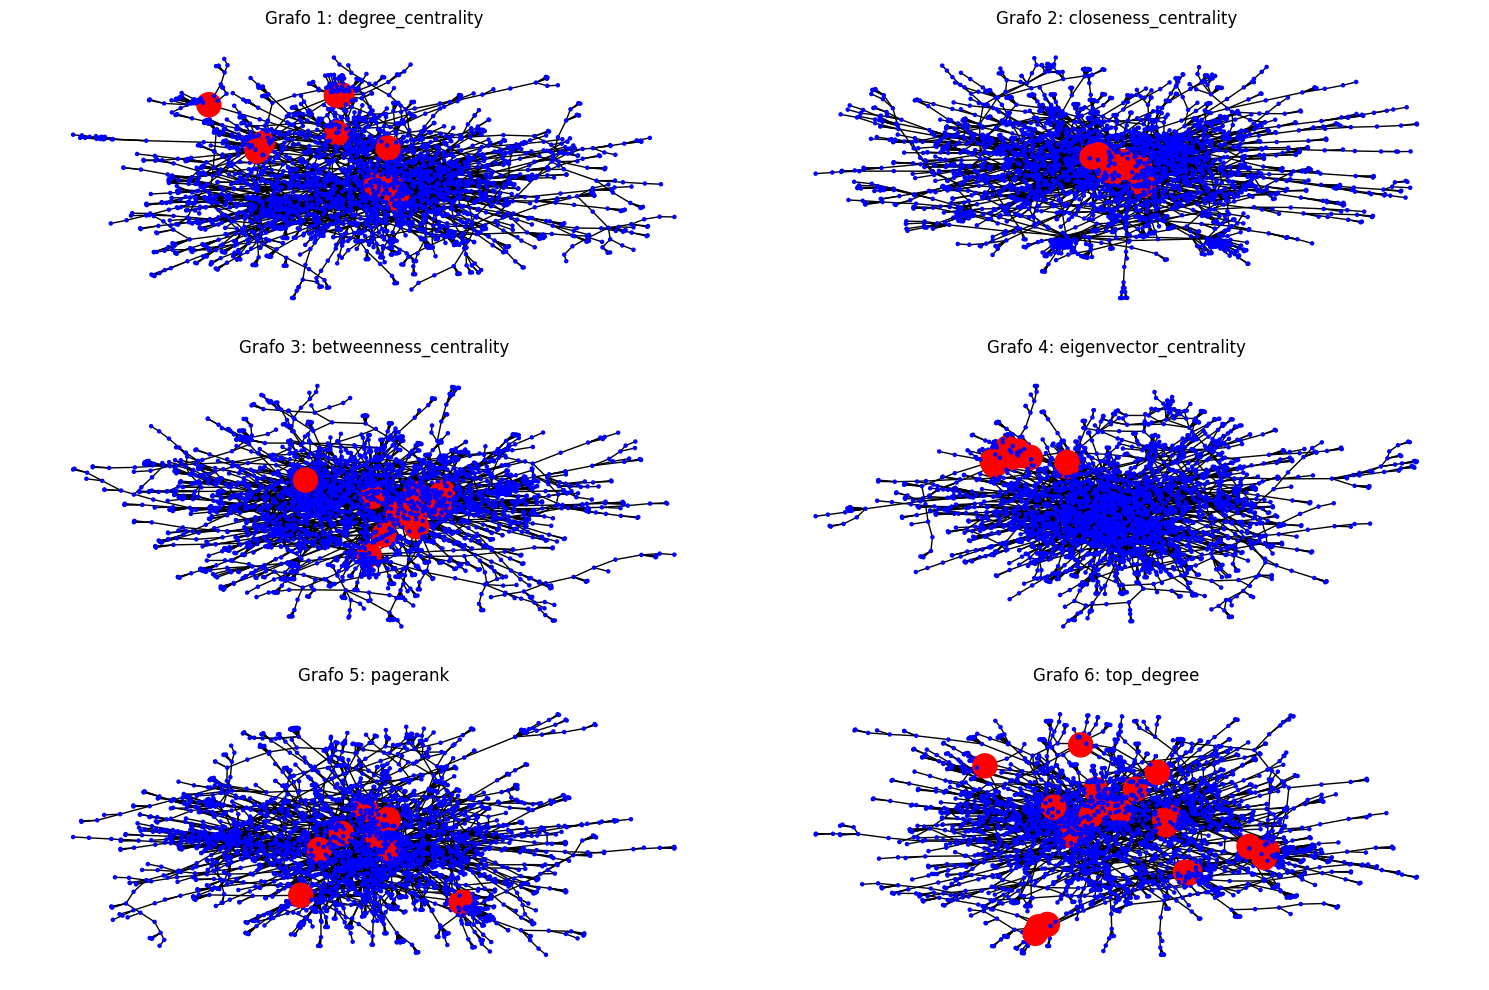

In [29]:
# Função para calcular centralidade e retornar resultados, node_size e node_color
def plot_centralidade(centrality, G, **kwargs):
    results = centrality(G, **kwargs)
    sorted_nodes = sorted(results, key=results.get, reverse=True)
    top_nodes = sorted_nodes[:10]
    node_size = [300 if node in top_nodes else 5 for node in G.nodes() ]
    node_color = ['red' if node in top_nodes else 'blue' for node in G.nodes()]
    return top_nodes, node_size, node_color

# Lista de centralidades para calcular e plotar
centralidade = [
    {'function': nx.degree_centrality, 'props': {}},
    {'function': nx.closeness_centrality, 'props': {}},
    {'function': nx.betweenness_centrality, 'props': {}},
    {'function': nx.eigenvector_centrality, 'props': {'max_iter': 1000}},
    {'function': nx.pagerank, 'props': {'alpha': 0.85, 'max_iter': 1000, 'weight': 'weight'}},
]

# Configuração da figura e dos subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.flatten()  # Flatten para iterar facilmente

# Iterar sobre as centralidades e plotar cada grafo em um subplot
usuarios_centrais = []
for i, c in enumerate(centralidade):
    # Calcular centralidade e obter node_size e node_color
    results, node_size, node_color = plot_centralidade(c['function'], G, **c['props'])
    usuarios_centrais.extend(results)
    # Plotar o grafo no subplot atual
    nx.draw(G, ax=axs[i], node_size=node_size, node_color=node_color, with_labels=False, cmap=plt.cm.Blues);
    axs[i].set_title(f"Grafo {i+1}: {c['function'].__name__}");
    print(f"{c['function'].__name__}:\n Intersecção (top_degree): {top_degree.intersection(set(results))}\n Usuários Centrais: {results}\n\n")

node_size = [300 if node in top_degree else 5 for node in G.nodes() ]
node_color = ['red' if node in top_degree else 'blue' for node in G.nodes()]
nx.draw(G, ax=axs[5], node_size=node_size, node_color=node_color, with_labels=False, cmap=plt.cm.Blues);
axs[5].set_title(f"Grafo {6}: top_degree");

# Ajustar layout e mostrar a figura
plt.tight_layout()
plt.show()


Assim, com base nos dados acima, verificamos que existe uma boa superposição entre as medidas de centralidade PageRank e o Grau, bem como que os nós centrais que podem ocupar posições mais centrais (grafo 2) ou que podem estar mais afastados do centro do grafo (grafos 1, 4 e 6). Enfim, não há um padrão bem delimitado na disposição das medidas de centralidade. Por outro lado, não existem razões que impeçam o uso de todos esses usuários como usuários centrais da rede social. Por essas razões, optaremos por utilizar como nós de centralidade todos os usuário encontrados com os algoritmos de medidas de centralidade, destacando-se que não são numerosos e existe uma boa intersecção de usuários nos conjuntos considerados - conforme podemos vislumbrar no comparativo abaixo:

In [30]:
top_degree = set(top_degree)
usuarios_centrais = set(usuarios_centrais)
print(f'O conjunto dos usuários com maior grau possuem um total de {len(top_degree)} usuários.')
print(f'O conjunto dos usuários centrais (medidas de centralidade) possuem um total de {len(usuarios_centrais)} usuários.')
print(f'O conjunto de intersecção possui um total de {len(usuarios_centrais.intersection(top_degree))} usuários.')

O conjunto dos usuários com maior grau possuem um total de 25 usuários.
O conjunto dos usuários centrais (medidas de centralidade) possuem um total de 33 usuários.
O conjunto de intersecção possui um total de 12 usuários.


Assim, haverá uma variedade interessante de dados que irão representar os usuários mais centrais (oriundos de diferentes medidas de centralidade), mas, ao mesmo tempo, possuem intersecção com os usuários mais comunicativos. Esses fatores contribuem para encontrarmos as mensagens que mais circulam na rede social ou os assuntos mais em evidência, o que interessa ao objetivo do trabalho. Na sequência, iremos reservar as informações sobre os usuários centrais e iremos promover uma interpretação das mensagens dos usuários utilizando redes complexas.

# Análise das Mensagens

Dentro dos objetivos desse trabalho, temos o intuito de realizar a análise de sentimento dos tweets de forma individual e de forma coletiva (grupos de usuários). Ao longo da jornada, gostaríamos de comparar situações distintas, utilizando o texto das mensagens de formas variadas, por exemplo, texto natural da publicação (sem alterações), texto previamente pré-processado e texto proveniente de extração de palavras centrais de cada uma das mensagens. Dessa forma, poderemos comparar os resultados e tirar conclusões.

### Construção dos Grafos das Mensagens

Em primeiro lugar, é preciso esclarecer que iremos utilizar as redes complexas para montar grafos a partir das mensagens dos usuários e extrair as palavras centrais (usando medidas de centralidade trabalhadas no grafo da rede social). Todavia, antes de montar esse grafo, iremos realizar o preprocessamento do texto para retirar todo tipo de acentuação, dígitos, excessos de espaços e cedilhas, bem como iremos normalizar os caracteres da mensagem em minúsculos. 

Por outro lado, é importante ressaltar que não iremos retirar palavras com 1 ou 2 caracteres, nem as _stop words_. Em textos convencionais, que usam a linguagem formal, essas palavras teriam pouco impacto na semântica da frase; porém, palavras com poucos caracteres são frequentes em redes do tipo microblog (em razão de abreviações, como, por exemplo, you = u) e as stopwords normalmente servem como palavras de conexão com outras palavras. Por isso, a retirada das palavras com poucos caracteres ou as _stop words_ podem gerar bastante dano na construção dos grafos das mensagens.

Uma vez pontuadas as informações acima, poderemos utilizar a sequência das palavras para montar o grafo. Por exemplo: iremos preprocessar o texto, preparar o grafo e coletar todas as suas informações (tais como as medidas do grafo e as palavras centrais). Esses dados serão armazenados em um dataframe para análises posteriores.

### Exemplo do Grafo e das Medidas

A título de exemplo, iremos montar o grafo e coletar as informações da seguinte forma:

Texto da mensagem:
 Tryna dnwload the beatksking app for my 3g... But there is no WiFi right now! Sonofva! &amp; I have a sick beat in my head! No Fair! 
Texto preprocessado:
 ['tryna', 'dnwload', 'the', 'beatksking', 'app', 'for', 'my', 'g', 'but', 'there', 'is', 'no', 'wifi', 'right', 'now', 'sonofva', 'amp', 'i', 'have', 'a', 'sick', 'beat', 'in', 'my', 'head', 'no', 'fair', '']
Medidas do Grafo:
	Number of nodes: 		 26
	Number of edges: 		 27
	1º Momentum: 			 2.077
	2º Momentum: 			 4.692
	Variância Momentum: 		 0.379
	Average Clustering: 		 0.0
	Shannon Entropy: 		 0.773
	Transitivity: 			 0
	Diameter: 			 13
	Global Efficiency: 		 0.295
	Local Efficiency: 		 0.0
	Average Shortest Path Lenght: 	 5.037
	Assortativity Coefficient: 	 -0.12
	Mean Degree: 			 2.077
	Closeness Centrality: 		 0.207
	Betwenees Centrality: 		 0.168
	Average Eigenvector Centrality:  0.149
	Page rank: 			 0.038
Palavras Centais do Grafo:
	Degree Centrality:	 ['my', 'no', 'dnwload', 'the', 'beatksking', 'app

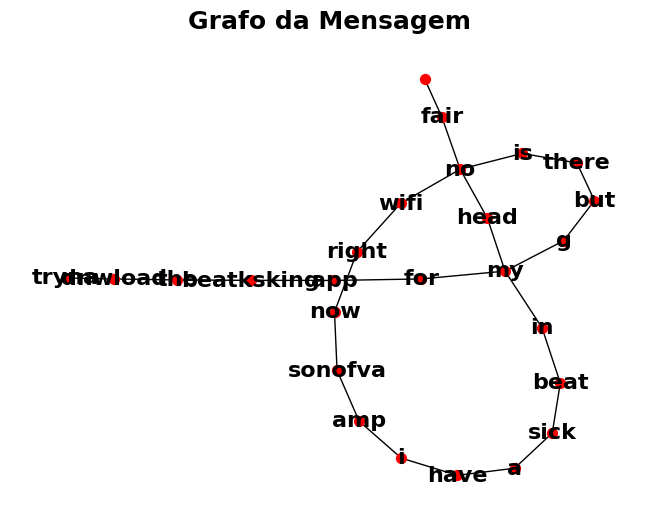

In [31]:
# Carregando mensagem de 'SusanCosmos'
text = df.iloc[12675, 5]
preprocessed = preprocessing_text(text)
G_text = graph_build(preprocessed)

# Textos Original e Preprocessado
print('Texto da mensagem:\n', text)
print('Texto preprocessado:\n', preprocessed)

# Cálculo das Medidas do Grafo
print('Medidas do Grafo:')
graph_calculate_measures(G_text, printing=True)

# Palavras centrais
print('Palavras Centais do Grafo:')
graph_identify_keywords(G_text, printing=True)

# Plot do Grafo
pos = nx.spring_layout(G_text)
nx.draw(G_text, pos, with_labels=True, node_color='red', node_size=50, font_size=16, font_weight='bold')
plt.title('Grafo da Mensagem', fontsize=18, fontweight='bold')
plt.show()

### Processamento das Mensagens

O primeiro passo para o processamento das mensagens é realizar a extração daquelas mensagens que são dos usuários do grafo da rede social. Isso irá trazer benefícios de performance computacional fornecendo uma visão de parte da realidade.Além disso, poderemos transformar as mensagens em grafos, sendo certo que, na sequência, poderemos extrair métricas e características relevantes para interpretar as mensagens da rede social. 

Nesse caso, podemos começar extraindo os dados:

In [32]:
# Coletando o nome dos usuários que estão presentes no grafo
users_graph = list(G.nodes())

# Filtragem das mensagens dos usuários do grafo
tweets = df.loc[df['user'].isin(users_graph)]

# Ajuste de index e informações da base
tweets = tweets.reset_index()
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49024 entries, 0 to 49023
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   49024 non-null  int64 
 1   target  49024 non-null  int64 
 2   ids     49024 non-null  int64 
 3   date    49024 non-null  object
 4   flag    49024 non-null  object
 5   user    49024 non-null  object
 6   text    49024 non-null  object
dtypes: int64(3), object(4)
memory usage: 2.6+ MB


In [33]:
tweets.head(5)

index  target         ids                          date      flag  \
0    169       0  1467855981  Mon Apr 06 22:31:37 PDT 2009  NO_QUERY   
1    252       0  1467875208  Mon Apr 06 22:36:39 PDT 2009  NO_QUERY   
2    262       0  1467878057  Mon Apr 06 22:37:26 PDT 2009  NO_QUERY   
3    328       0  1467895109  Mon Apr 06 22:42:00 PDT 2009  NO_QUERY   
4    349       0  1467899451  Mon Apr 06 22:43:12 PDT 2009  NO_QUERY   

              user                                               text  
0   Hollywood_Trey  @naughtyhaughty I had on my page for sooooo lo...  
1           realin  Damn i am so late at filling this appraisal fo...  
2  debbieseraphina         help me forget 8th april &amp; 13th july!   
3  IncomeDiscovery  @vene2ia ...not yet unfortunately, another few...  
4        aileen2u2  @Dangerm0use I think maybe you should get a co...

Considerando que temos as mensagens disponíveis, podemos processar os dados e extrair métricas de interesse, tais como a quantidade de palavras utilizadas na construção das mensagens (nodes), quantidade de conexões (edges), momento 1, momento 2, variancia, propensão dos vizinhos estares conectados entre si (Average Clustring), medida da incerteza na distribuição dos graus dos vértices (Shannon Entropy), proporção de triângulos fechados em relação ao máximo de triângulos possíveis no grafo (Transitivity), maior distância mais curta entre quaisquer dois vértices do grafo (Diameter), eficiência global de comunicação no grafo (Global Efficiency), eficiência local de comunicação dentro das comunidades (Local Efficiency) e o tamanho médio entre todos os pares de vértices do grafo (Average Shortest Path). Por outro lado, também podemos utilizar as medidas de centralidade mencionadas anteriormente para calcular as palavras mais importantes.

In [34]:
# Conjunto de palavras obtidas por meio das medidas de centralidade
df_keywords = pd.DataFrame(columns=[
    'id','Keyword Degree','Keyword Pagerank','Keyword Betweenness','Keyword Closeness',
    'Keyword Eigenvector'])

# Métricas a serem calculadas a partir dos grafos das mensagens
df_metrics = pd.DataFrame(columns=[
    'id','Nodes','Edges','Momento 1','Momento 2','Variance','Average Clustering',
    'Shannon Entropy','Transitivity','Diameter', 'Global Efficiency', 'Local Efficiency',
    'Average Shortest Path', 'Mean Degree', 'Average Closeness Centrality', 
    'Average Betweenness Centrality', 'Average Eigenvector Centrality'])

# Preprocessamento do texto das mensagens
tweets['preprocessed'] = tweets['text'].apply(lambda x: preprocessing_text(str(x)))

# Processamento
for indice, _ in tweets.iterrows():

    try:
        # Construção do grafo das mensagens
        G_text = graph_build(tweets.iloc[indice, 7])

        # Calculando Medidas e Palavras Centrais
        measures = graph_calculate_measures(G_text)
        sorted_keywords = graph_identify_keywords(G_text, 10)

        # Armazenando Dados
        df_metrics.loc[df_metrics.shape[0]] = {
            'id': tweets.iloc[indice, 0],
            'Nodes': measures[0],
            'Edges': measures[1],
            'Momento 1': measures[2],
            'Momento 2': measures[3],
            'Variance': measures[4],
            'Average Clustering': measures[5],
            'Shannon Entropy': measures[6],
            'Transitivity': measures[7],
            'Diameter': measures[8],
            'Global Efficiency': measures[9],
            'Local Efficiency': measures[10],
            'Average Shortest Path': measures[11],
            'Mean Degree': measures[12],
            'Average Closeness Centrality': measures[13],
            'Average Betweenness Centrality': measures[14],
            'Average Eigenvector Centrality': measures[15],
        }

        df_keywords.loc[df_keywords.shape[0]] = {
            'id': tweets.iloc[indice, 0],
            'Keyword Degree':sorted_keywords[0],
            'Keyword Pagerank':sorted_keywords[1],
            'Keyword Betweenness':sorted_keywords[2],
            'Keyword Closeness':sorted_keywords[3],
            'Keyword Eigenvector':sorted_keywords[4]
        }
    except:
        continue

# Transformações póstumas (como união das informações 
# por meio de uma JOIN entre as tabelas e dispensa da coluna id)
merged = pd.merge(df_keywords, df_metrics, on=['id'], how='inner')
tweets = pd.merge(tweets, merged, right_on='id', left_on='index', how='inner')
tweets = tweets.drop(columns=['id'])

### Análise Quantitativa das Métricas das Mensagens

A primeira das análises que podemos fazer em uma interpretação das mensagens é interpretar quantitativamente os dados que nos são apresentados. Nesse contexto, podemos analisar os seguintes aspectos:

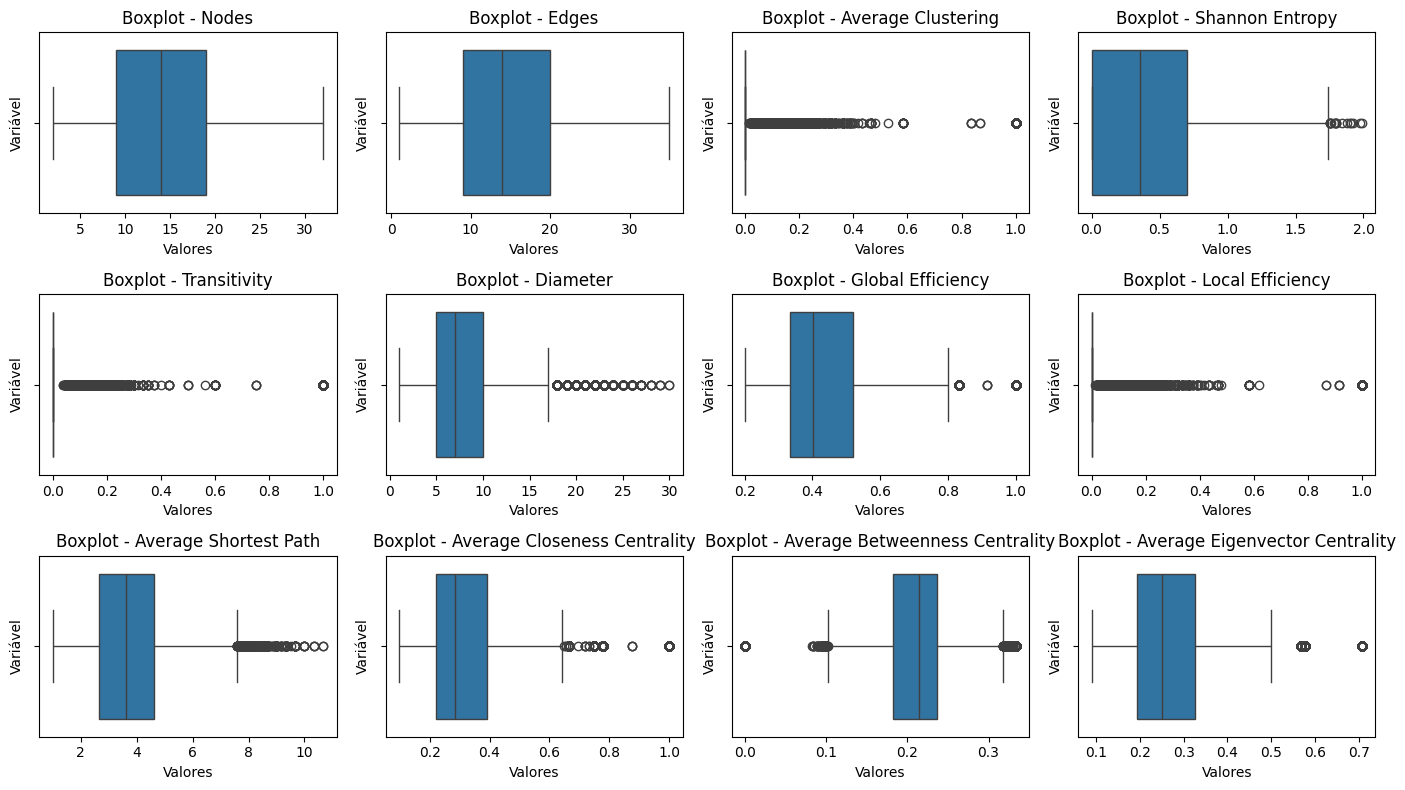

In [35]:
# Ajuste dos Dados e Labels
all_data = [tweets['Nodes'], tweets['Edges'], tweets['Average Clustering'], tweets['Shannon Entropy'], tweets['Transitivity'], tweets['Diameter'], tweets['Global Efficiency'], tweets['Local Efficiency'], tweets['Average Shortest Path'], tweets['Average Closeness Centrality'], tweets['Average Betweenness Centrality'], tweets['Average Eigenvector Centrality']]
labels = ['Nodes','Edges','Average Clustering','Shannon Entropy','Transitivity','Diameter','Global Efficiency','Local Efficiency', 'Average Shortest Path', 'Average Closeness Centrality','Average Betweenness Centrality','Average Eigenvector Centrality']

# Configuração da figura e subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(14, 8))

# Loop para plotar os boxplots
for i, ax in enumerate(axes.flatten()):
    sns.boxplot(x=all_data[i], ax=ax)
    ax.set_title(f'Boxplot - {labels[i]}')
    ax.set_xlabel('Valores')
    ax.set_ylabel('Variável')

# Ajusta o layout
plt.tight_layout()
plt.show()

Analisando os dados acima, percebemos as seguinte informações:

* A quantidades de vértices (Nodes) acompanha a quantidade de arestas (Edges). Isso ocorre porque amplitude dos dados é muita parecida (variando de pouco mais de 0 até pouco mais de 30), assim como a distribuição da média (por volta de 14) e dos quartis (por volta de 10 ou 20). Por isso, podemos entender que a quantidade de palavras é próxima a quantidade de arestas, mostrando que os usuários não repetem ou repetem muito pouco as palavras utilizadas em uma mesma mensagem.

* As medidas de Average Clustering (forte tendência a 0 - zero) e Shannon Entropy (valores baixos - em média 0.4) seguem a mesma interpretação vista acima, pois indicam que as palavras possuem pouca conexões entre seus vizinhos e alguns poucos vizinhos muito conectados em relação à maioria.

* A Transitivity, por sua vez, mostra que não existe uma tendência de o grafo formar agrupamentos de três vértices, o que demonstra grafos menos ramificados e mais lineares.

* O Diameter é a medida da extensão máxima da rede (maior distância mais curta entre quaisquer dois vértices no grafo). No caso, verificamos que a distância média é em torno de 6 ou 7 palavras, mas cerca de 50% das palavras estão entre um pouco mais que 0 e um pouco mais que 15. Ou seja, são frases realmente pequenas.

* Comparando as medidas de Global Efficiency (0.2 a 0.8 com média de 0.4) e Local Efficiency (tendendo a 0), percebemos que existe uma tendência da comunicação se dar com a semântica da mensagem inteira e não com apenas partes dela, o que já era esperado, uma vez que estamos lidando com mensagens de tamanho bastante restritto.

* Por meio do Average Shortest Path percebemos que o comprimento médio que as informações percorrem na rede varia entre 1 e 8 (média próxima de 4). Isso está de acordo com o Diameter, pois as mensagens tendem a ter o mesmo tamanho em número de palavras para transmitir a informação.

* Com base nos Average Closeness Centrality, Average Betweenness Centrality e Eigenvector Centrality, percebemos que existe pouca tendência de interação ou proximidade entre as palavras dos grafos.

### Análise Semântica das Mensagens

A análise semântica das palavras utilizadas nas mensagens pode ser bastante interessante para entendermos a análise de sentimentos. Podemos realizar essa análise de duas formas:

* **_Considernado StopWords_**: as StopWords são consideradas palavras muito comuns e com pouca carga semântica, sendo certo que geralmente são filtradas ou removidas durante o processamento de texto em tarefas de processamento de linguagem natural (PLN). Normalmente, inclui artigos, preposições, conjunções e alguns advérbios. Porém, como estamos tratando de mensagens limitadas, podem existir abreviações, siglas ou expressões que devem ser consideradas para a semântica do texto. Por essa razão, optamos por analisar as palavras mais frequentes nas mensagens. No caso, iremos utilizar apenas um gráfico de frequência simples mostrando as 50 palavras mais frequentes em todas as mensagens.

* **_Retirando StopWords_**: pode ser interessante observar a interpretação de palavras com maior carga semântica. Por essa razão, também optamos por realizar a interpretação das palavras dessa forma. Nesse cenário, iremos utilizar o Wordcloud, que é um algoritmo que retira as stopwords e mostra as palavras com tamanho tanto maior quanto mais frequente a palavra for em um determinado contexto.

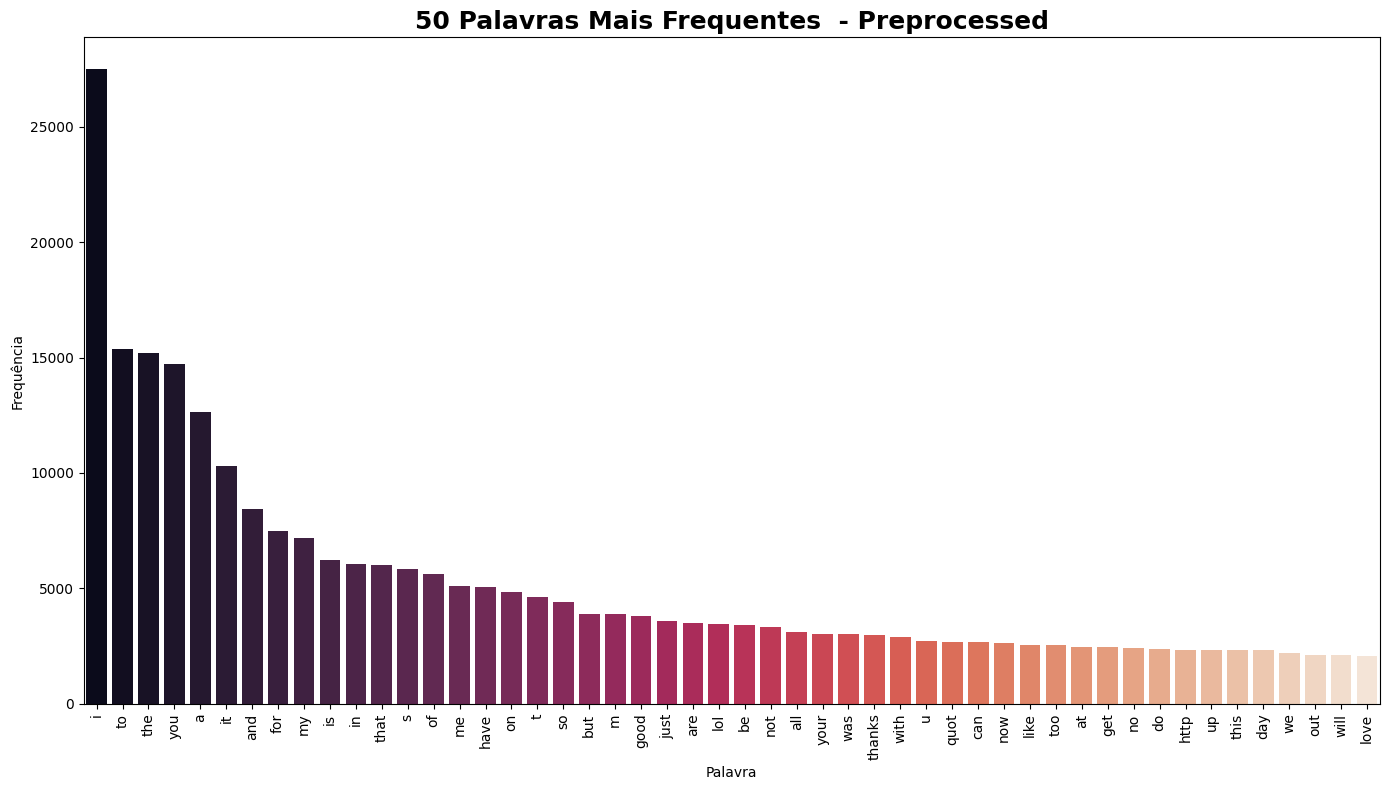

In [36]:
# Coletando as palavras preprocessadas (considerando as StopWords)
preprocessed = []
tweets['preprocessed'].apply(lambda x: preprocessed.extend(x))
preprocessed = [e for e in preprocessed if e != '']

# Plotando o Gráfico das palavras mais frequentes
mf = graph_x_word_most_frequent(50, preprocessed, 'Preprocessed')

Observações sobre a semântica das palavras:

* É possível verificar um predomínio da palavra "I" ('eu') sobre as demais, bem como existe o uso do "we" ('nós'). Isso tende a mostrar um forte viés de que as mensagens tomam como referência linguística a pessoa que faz a transmissão da mensagem. Outras palavras reforçam essa ideia, tais como "my" ('minha') e "me" ('mim'). 

* A enunciação da mensagem é direcionada para uma pessoa próxima do enunciador, uma vez que são frequentes as palavras "to" ('para') e "you" ('você') ou talvez "your" ('seus').

* A palavra "at" ('em') sugere que as pessoas façam postagens mostrando onde estão localizadas.

* A palavra "http" sugere que as mensagens façam indicações de websites ou postem imagens existentes na rede.

* As palavras "this" ('este') e "day" ('dia'), assim como a "now" ('agora'), parecem indicar que o enunciador da mensagem está falando do dia ou momento atual.

* A tonalidade das palavras que apresentam maior carga semântica tendem a trazer sentimentos positivos, tais como "good" ('bom'), lol (acrônimo de 'laugh and loud', que singifica muitas risadas), 'thanks' ('agradecimentos'), like (pode servir como comparativo ou como o verbo 'gostar') e "love" ('amor').

De forma resumida, podemos verificar um referencial de mundo centrado no enunciador da mensagem, sendo certo que ele foca no momento atual para direcionar a mensagem a uma pessoa próxima a ele. Essas mensagens, no caso específico das mensagens analisadas, demonstram um sentimento positivo. Por outro lado, Por outro lado, retirando as StopWords, percebemos que a interpretação em pouco se altera:

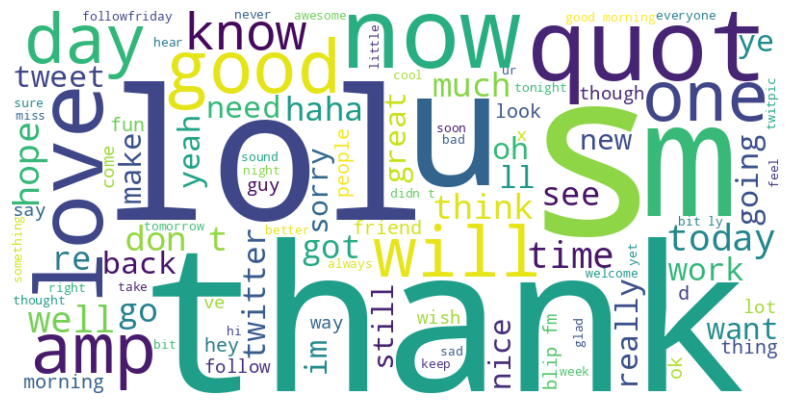

In [37]:
# Plotando a WordCloud sem StopWords (mostrando 100 palavras)
cloud(' '.join(preprocessed), 100)

### Análise de Sentimentos das Mensagens

In [38]:
# Análise de sentimento do texto natural
tweets['Vader Text'] = tweets['text'].apply(lambda x: sentiment_vader(x))
tweets['TextBlob Text'] = tweets['text'].apply(lambda x: sentiment_textblob(x))

In [39]:

# Análise de sentimento das palavras centrais
cols = ['preprocessed', 'Keyword Degree', 'Keyword Pagerank','Keyword Betweenness', 'Keyword Closeness', 'Keyword Eigenvector']
for c in cols:
    tweets['TextBlob '+c] = tweets[c].apply(lambda x: sentiment_textblob(" ".join(x)))
    tweets['Vader '+c] = tweets[c].apply(lambda x: sentiment_vader(" ".join(x)))


In [40]:
tweets.head(5)

index  target         ids                          date      flag  \
0    169       0  1467855981  Mon Apr 06 22:31:37 PDT 2009  NO_QUERY   
1    252       0  1467875208  Mon Apr 06 22:36:39 PDT 2009  NO_QUERY   
2    262       0  1467878057  Mon Apr 06 22:37:26 PDT 2009  NO_QUERY   
3    328       0  1467895109  Mon Apr 06 22:42:00 PDT 2009  NO_QUERY   
4    349       0  1467899451  Mon Apr 06 22:43:12 PDT 2009  NO_QUERY   

              user                                               text  \
0   Hollywood_Trey  @naughtyhaughty I had on my page for sooooo lo...   
1           realin  Damn i am so late at filling this appraisal fo...   
2  debbieseraphina         help me forget 8th april &amp; 13th july!    
3  IncomeDiscovery  @vene2ia ...not yet unfortunately, another few...   
4        aileen2u2  @Dangerm0use I think maybe you should get a co...   

                                        preprocessed  \
0  [, naughtyhaughty, i, had, on, my, page, for, ...   
1  [damn, i, am, so, late, at, filling, this, app...   
2     [help, me, forget, th, april, amp, th, july, ]   
3  [, veneia, not, yet, unfortunately, another, f...   
4  [, dangermuse, i, think, maybe, you, should, g...   

                                      Keyword Degree  \
0  [naughtyhaughty, i, had, on, my, page, for, so...   
1  [i, so, am, late, at, filling, this, appraisal...   
2         [th, me, forget, april, amp, july, help, ]   
3  [i, been, , veneia, not, yet, unfortunately, a...   
4  [i, you, , dangermuse, think, maybe, should, g...   

                                    Keyword Pagerank  ...  \
0  [naughtyhaughty, in, i, day, had, sad, on, del...  ...   
1  [i, so, work, in, form, people, appraisal, hav...  ...   
2         [th, me, july, forget, april, amp, help, ]  ...   
3  [i, been, , project, veneia, latest, not, my, ...  ...   
4  [you, i, hours, of, more, sleep, couple, hon, ...  ...   

  TextBlob Keyword Degree Vader Keyword Degree TextBlob Keyword Pagerank  \
0                   -0.05               0.0000                      -0.5   
1                   -0.30               0.0000                       0.0   
2                    0.00               0.2023                       0.0   
3                   -0.35               0.2584                       0.5   
4                    0.00               0.0000                       0.5   

   Vader Keyword Pagerank  TextBlob Keyword Betweenness  \
0                 -0.4767                     -0.050000   
1                  0.0000                     -0.300000   
2                  0.2023                      0.000000   
3                  0.0000                     -0.295833   
4                  0.0000                      0.000000   

   Vader Keyword Betweenness  TextBlob Keyword Closeness  \
0                     0.0000                   -0.050000   
1                     0.0000                   -0.300000   
2                     0.2023                    0.000000   
3                    -0.2815                   -0.295833   
4                     0.0000                    0.285714   

   Vader Keyword Closeness  TextBlob Keyword Eigenvector  \
0                   0.0000                         -0.05   
1                   0.0000                         -0.30   
2                   0.2023                          0.00   
3                  -0.2815                         -0.20   
4                   0.0000                         -0.40   

   Vader Keyword Eigenvector  
0                     0.0000  
1                    -0.4019  
2                     0.2023  
3                     0.0000  
4                    -0.7003  

[5 rows x 43 columns]

In [41]:
tweets.columns[29:]

Index(['Vader Text', 'TextBlob Text', 'TextBlob preprocessed',
       'Vader preprocessed', 'TextBlob Keyword Degree', 'Vader Keyword Degree',
       'TextBlob Keyword Pagerank', 'Vader Keyword Pagerank',
       'TextBlob Keyword Betweenness', 'Vader Keyword Betweenness',
       'TextBlob Keyword Closeness', 'Vader Keyword Closeness',
       'TextBlob Keyword Eigenvector', 'Vader Keyword Eigenvector'],
      dtype='object')

In [42]:
def prediction_tostring(x):
    if x >= 0: return 'positive'
    return 'negative'

col = tweets.columns[29:]
for c in col: tweets[c] = tweets[c].apply(lambda x: prediction_tostring(x))
tweets['target'] = tweets['target'].apply(lambda x: 'positive' if x == 4 else 'negative')
tweets['target'].value_counts()

target
positive    34424
negative    14592
Name: count, dtype: int64

In [43]:
tweets.head(5)

index    target         ids                          date      flag  \
0    169  negative  1467855981  Mon Apr 06 22:31:37 PDT 2009  NO_QUERY   
1    252  negative  1467875208  Mon Apr 06 22:36:39 PDT 2009  NO_QUERY   
2    262  negative  1467878057  Mon Apr 06 22:37:26 PDT 2009  NO_QUERY   
3    328  negative  1467895109  Mon Apr 06 22:42:00 PDT 2009  NO_QUERY   
4    349  negative  1467899451  Mon Apr 06 22:43:12 PDT 2009  NO_QUERY   

              user                                               text  \
0   Hollywood_Trey  @naughtyhaughty I had on my page for sooooo lo...   
1           realin  Damn i am so late at filling this appraisal fo...   
2  debbieseraphina         help me forget 8th april &amp; 13th july!    
3  IncomeDiscovery  @vene2ia ...not yet unfortunately, another few...   
4        aileen2u2  @Dangerm0use I think maybe you should get a co...   

                                        preprocessed  \
0  [, naughtyhaughty, i, had, on, my, page, for, ...   
1  [damn, i, am, so, late, at, filling, this, app...   
2     [help, me, forget, th, april, amp, th, july, ]   
3  [, veneia, not, yet, unfortunately, another, f...   
4  [, dangermuse, i, think, maybe, you, should, g...   

                                      Keyword Degree  \
0  [naughtyhaughty, i, had, on, my, page, for, so...   
1  [i, so, am, late, at, filling, this, appraisal...   
2         [th, me, forget, april, amp, july, help, ]   
3  [i, been, , veneia, not, yet, unfortunately, a...   
4  [i, you, , dangermuse, think, maybe, should, g...   

                                    Keyword Pagerank  ...  \
0  [naughtyhaughty, in, i, day, had, sad, on, del...  ...   
1  [i, so, work, in, form, people, appraisal, hav...  ...   
2         [th, me, july, forget, april, amp, help, ]  ...   
3  [i, been, , project, veneia, latest, not, my, ...  ...   
4  [you, i, hours, of, more, sleep, couple, hon, ...  ...   

  TextBlob Keyword Degree Vader Keyword Degree TextBlob Keyword Pagerank  \
0                negative             positive                  negative   
1                negative             positive                  positive   
2                positive             positive                  positive   
3                negative             positive                  positive   
4                positive             positive                  positive   

   Vader Keyword Pagerank  TextBlob Keyword Betweenness  \
0                negative                      negative   
1                positive                      negative   
2                positive                      positive   
3                positive                      negative   
4                positive                      positive   

   Vader Keyword Betweenness  TextBlob Keyword Closeness  \
0                   positive                    negative   
1                   positive                    negative   
2                   positive                    positive   
3                   negative                    negative   
4                   positive                    positive   

   Vader Keyword Closeness  TextBlob Keyword Eigenvector  \
0                 positive                      negative   
1                 positive                      negative   
2                 positive                      positive   
3                 negative                      negative   
4                 positive                      negative   

   Vader Keyword Eigenvector  
0                   positive  
1                   negative  
2                   positive  
3                   positive  
4                   negative  

[5 rows x 43 columns]

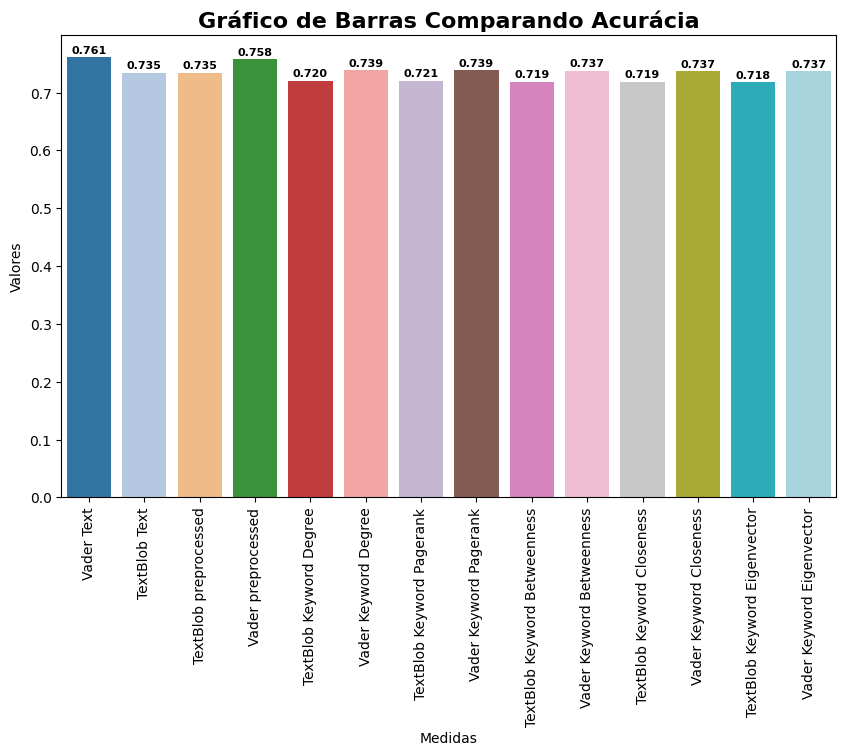

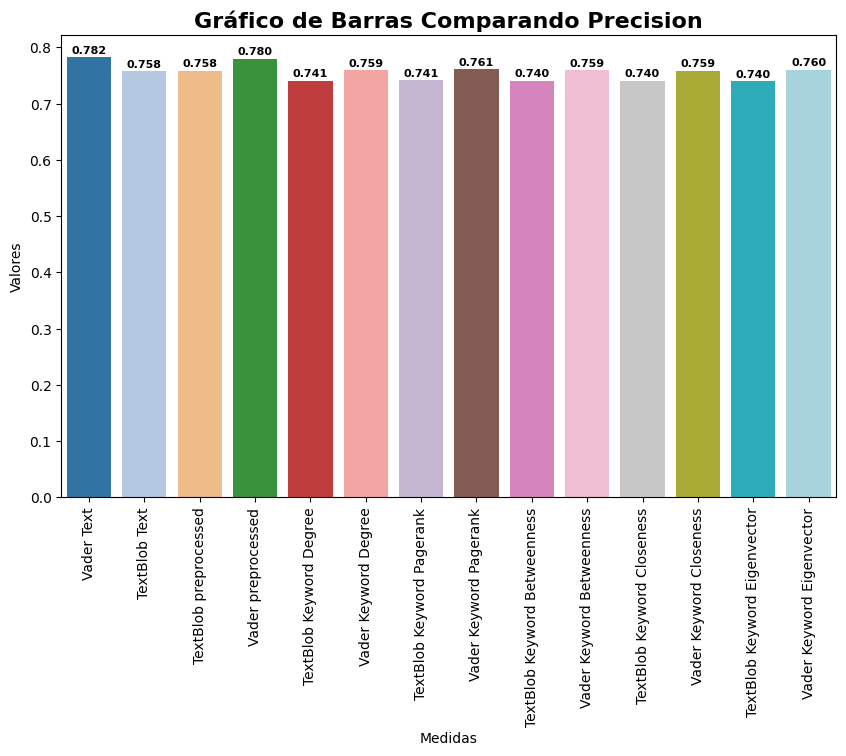

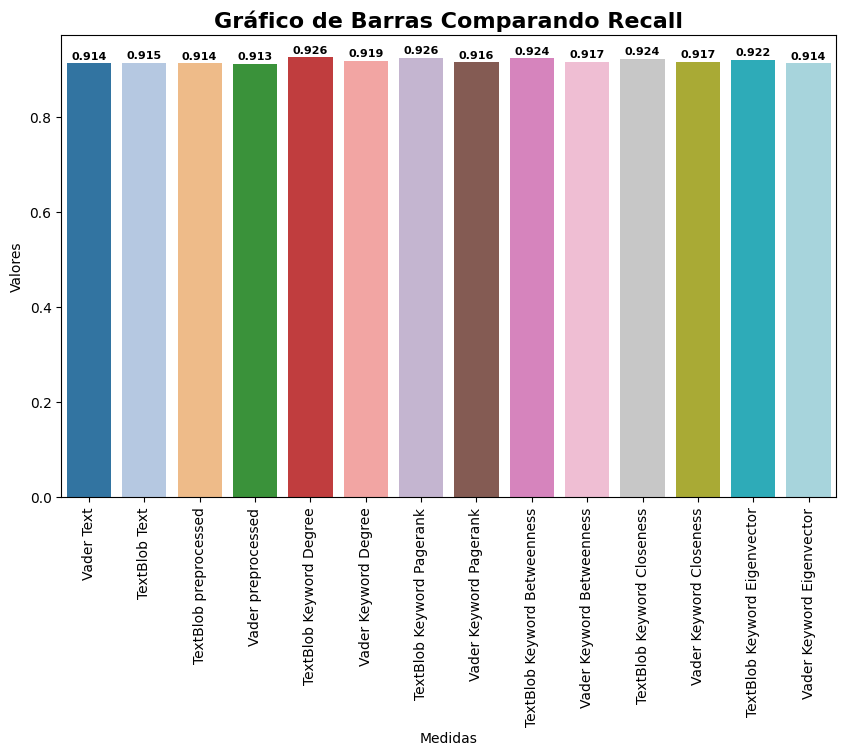

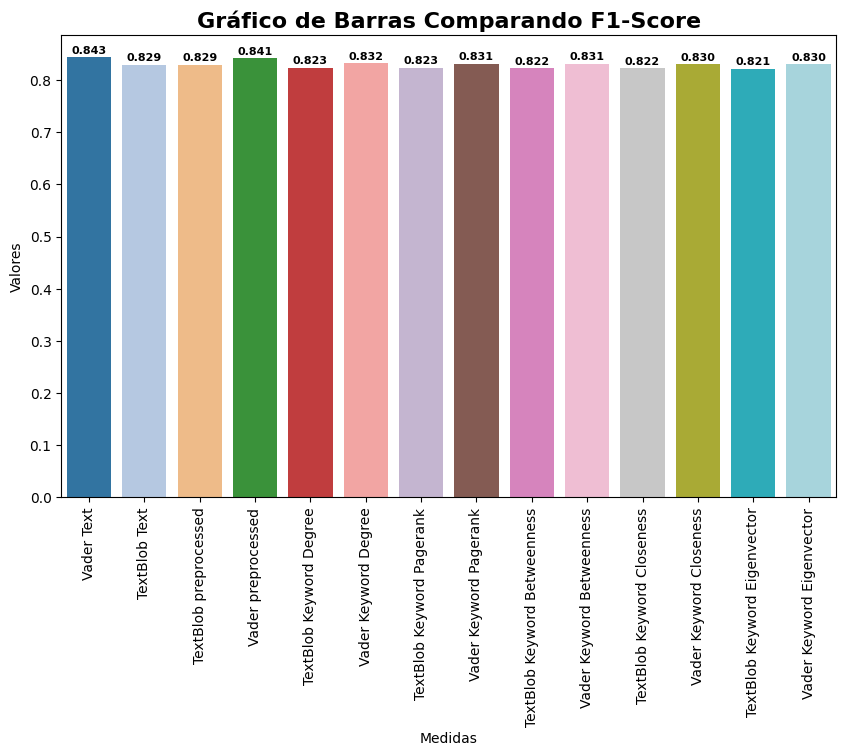

In [44]:
# Calcular medidas de avaliação
acuracia = {'Medidas': [], 'Valores': []}
precision = {'Medidas': [], 'Valores': []}
recall = {'Medidas': [], 'Valores': []}
f1score = {'Medidas': [], 'Valores': []}

for c in col:
    acuracia['Medidas'].append(c)
    acuracia['Valores'].append(accuracy_score(tweets['target'], tweets[c]))
    precision['Medidas'].append(c)
    precision['Valores'].append(precision_score(tweets['target'], tweets[c],pos_label='positive'))
    recall['Medidas'].append(c)
    recall['Valores'].append(recall_score(tweets['target'], tweets[c],pos_label='positive'))
    f1score['Medidas'].append(c)
    f1score['Valores'].append(f1_score(tweets['target'], tweets[c], pos_label='positive'))
   
metrics = {
    'Acurácia': acuracia,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1score
}

for m in metrics:
    # Definir o número de cores desejado (ajuste se necessário)
    num_cores = len(metrics[m]['Medidas'])  
    
    # Escolher o mapa de cores
    cmap = plt.colormaps['tab20']  # Escolha o mapa de cores desejado
    
    # Obter as cores do mapa de cores
    colors = [cmap(i) for i in np.linspace(0, 1, num_cores)]
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Medidas', y='Valores', data=metrics[m], palette=colors, hue=metrics[m]['Medidas'])

    for p in ax.patches:
        ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, fontweight='bold', color='black', xytext=(0, 5),
                textcoords='offset points')
    
    # Adicionar título
    plt.title(f'Gráfico de Barras Comparando {m}', fontsize=16, fontweight='bold')
    plt.xticks(rotation=90)
    
    # Exibir o gráfico
    plt.show()

Com base nos dados comparativos acima, percemos que existe pouca ou nenhuma variação entre os resultados da análise de sentimentos que recai sobre o texto inteiro (Vader Text e Textblob Text) em relação aos demais valores (TextBlob preprocessed, Vader preprocessed, TextBlob Keyword Degree, Vader Keyword Degree, TextBlob Keyword Pagerank, Vader Keyword Pagerank, TextBlob Keyword Betweenness,Vader Keyword Betweenness, TextBlob Keyword Closeness, Vader Keyword Closeness, TextBlob Keyword Eigenvector, Vader Keyword Eigenvector). Isso mostra que a extração de características operada pela rede complexa tem praticamente a mesma eficácia o algoritmo que considera o texto inteiro.

Além disso, percebemos também que os algoritmos de análise de sentimento erraram mais na predição dos verdadeiros positivos e acertaram mais na predição de verdadeiros negativos. Essa interpretação é adotada, pois, em termos quantitativos, a Recall é bem mais elevada que a Precision. Por isso, sugere que o algoritmo esteja errando mais na predição de sentimentos verdadeiros positivos.

### Análise de Sentimento em Comunidades

Após analisar o sentimento de cada usuário com base em sua rede complexa de comunicação, iremos verificar a possibilidade de identificar o sentimento predominante em cada comunidade, considerando as palavras mais recorrentes em cada grupo de usuários. Para isso, utilizaremos algoritmos de divisão em comunidades, como Louvain, Girvan-Newman e Greedy-Modularity. 

Após dividir os usuários em comunidades, avaliaremos o comportamento de cada grupo por meio da geração de uma nuvem de palavras que destacará as palavras mais frequentes. Além disso, calcularemos a média aritmética dos valores de sentimento (positivo = 1) e (negativo = -1) para descobrir o sentimento predominante em cada comuindade.

In [45]:
## Aplicação dos Algoritmos
greedy_dict = {user: i for i, c in enumerate(greedy_modularity_communities(G)) for user in list(c)}
girvan_dict = {user: i for i, c in enumerate(next(girvan_newman(G))) for user in c}
louvain_dict = community_louvain.best_partition(G)

# Armazenamento dos Dados
tweets['greedy_modularity'] = tweets['user'].map(greedy_dict)
tweets['girvan_newman'] = tweets['user'].map(girvan_dict)
tweets['louvain'] = tweets['user'].map(louvain_dict)

#### Comunidade de Louvain

O primeiro método de detecção de comunidades é algortimo de Louvain, desenvolvido por Blondel em que possui qualidades como ser eficiente e escalável, assim tornando ideal para grandes redes. Ele detecta comunidades maximizando a modularidade de uma rede em um processo hierárquico. Inicialmente, cada nó é atribuído a uma comunidade própria, e comunidades são unidas iterativamente para aumentar a modularidade. O processo continua até que a modularidade não possa mais ser aumentada.

Além disso, verificamos que foram encontradas 55 comunidades, as quais possuem quantidades diferentes de tweets. Por exemplo, as comunidades 1, 9, 27, 34 e 43 são as que mais possuem tweets e possivelmente desempenham uma papel de evidência na rede. Podemos verificar essa realidade vislumbrando se as mensagens são originadas nos usuários centrais da rede social. 

In [46]:
# Calculando total de comunidades
print(f'Total de comunidades: {len(set(louvain_dict.values()))}')

Total de comunidades: 61


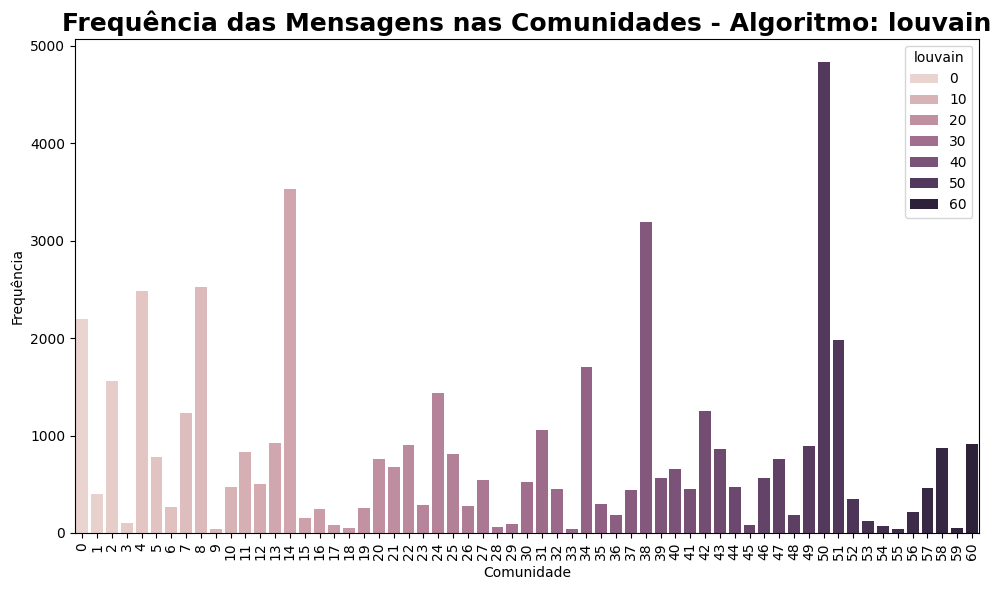

In [47]:
# Mostrar Frequência de Mensagens nas Comunidades
graph_communities_frequency(tweets, 'louvain')

In [48]:
# Verificando interseção entre usuários da rede social com as comunidades mais postadoras
users_louvain = set(tweets.loc[tweets['louvain'].isin(tweets['louvain'].value_counts().nlargest(5).index), 'user'])
intersection = users_louvain.intersection(usuarios_centrais)
print(f'Quantidade de usuários na intersecção: {len(intersection)}')
print('Interseção entre os Centrais do Grafo da Rede Social com os Usuários da Comunidade Lovain:')
print(intersection)


Quantidade de usuários na intersecção: 21
Interseção entre os Centrais do Grafo da Rede Social com os Usuários da Comunidade Lovain:
{'tommcfly', 'steph_davies', 'Djalfy', 'sophielovemcfly', 'laysxx', 'megpoynter', 'SusanCosmos', 'WalkInTheSun_', '_DINA', 'mharagao', 'JaxLicurse', 'epcotx', 'SomersetBob', 'MATT_369', 'jessicastrust', 'danipoynterjudd', 'PeaceDiva', 'TheTAZZone', 'mcflyharry', 'faithgoddess7', 'keren4562'}


De fato, existe uma sobreposição entre os usuários que são centrais na rede social e os usuários das comunidades que apresentam a maior quantidade de mensagens. Isso sugere que tanto o grau do vértice quanto a distribuição de mensagens em comunidades tendem a identificar os usuários mais conectados.

Além disso, podemos verificar também que os usuários das comunidades estão distribuídos da seguinte forma:

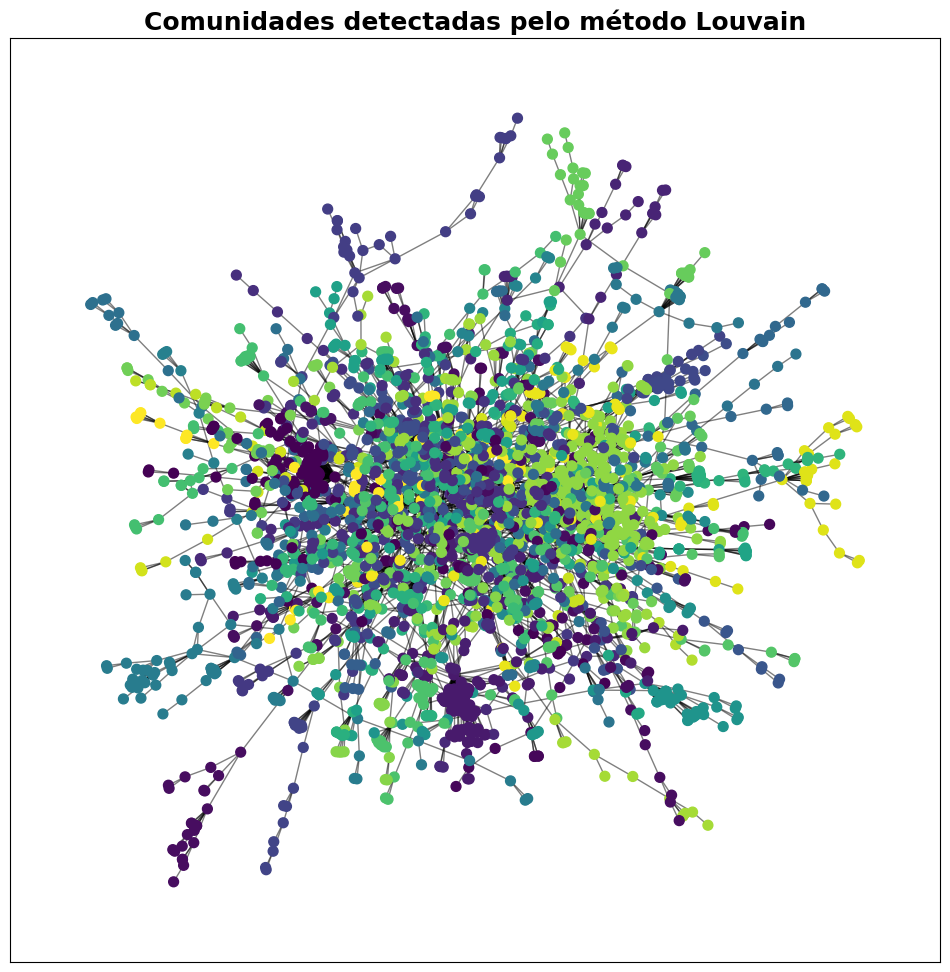

In [49]:
plot_communities(G, louvain_dict, 'Louvain')

Em resumo, o algoritmo de Louvain identificou 58 (cinquenta e oito) comunidades. No entanto, devido ao grande número de comunidades, não foi possível visualizar todas as distinções de forma clara. Ainda assim, conseguimos perceber a formação das comunidades pela aglomeração de cores iguais no nosso grafo.

#### Girvan-Newman

Já o segundo método selecionado é o algoritmo de Girvan-Newman que detecta comunidades removendo iterativamente arestas de maior centralidade de intermediação da rede. Ao fazer isso, a rede se divide em componentes menores, revelando a estrutura comunitária. É eficaz para redes com hierarquias claras e múltiplas escalas de comunidade.

In [50]:
# Calculando total de comunidades
print(f'Total de comunidades: {len(set(girvan_dict.values()))}')

Total de comunidades: 2


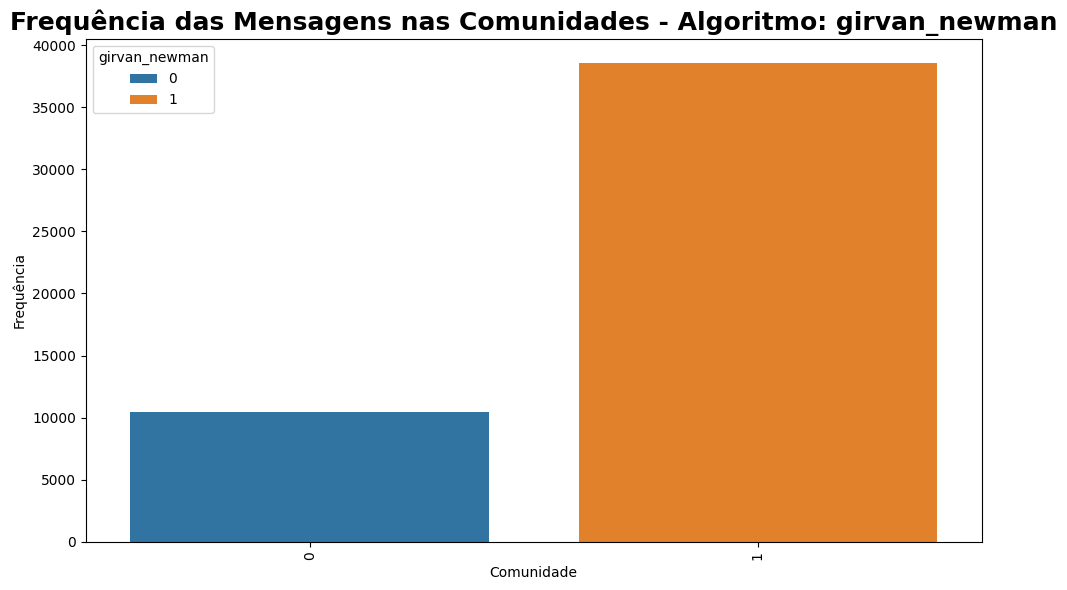

In [51]:
# Mostrar Frequência de Mensagens nas Comunidades
graph_communities_frequency(tweets, 'girvan_newman')

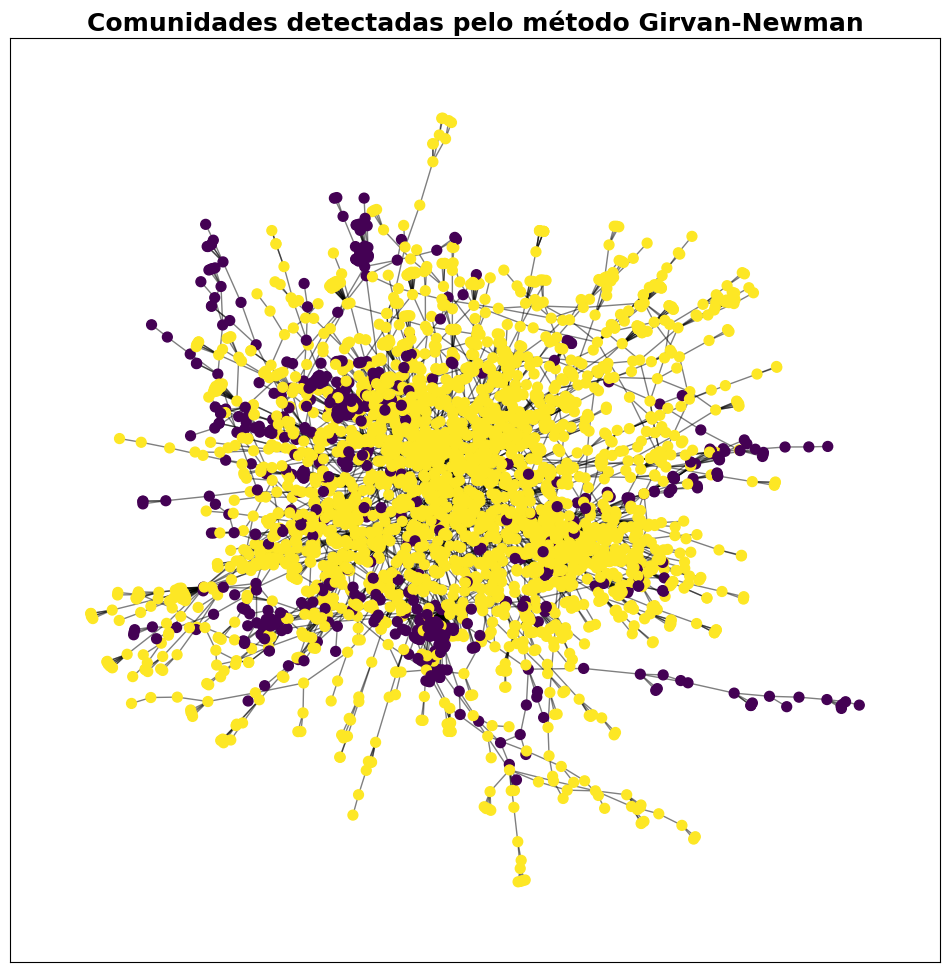

In [52]:
plot_communities(G, girvan_dict, 'Girvan-Newman')

O algoritmo de Girvan-Newman identificou duas comunidades, o que está de acordo com o escopo dos dados, que possuem duas categorias. No entanto, os resultados deste método diferem dos obtidos com outros métodos utilizados.

#### Greedy Modularity

Por fim, o último algoritmo selecionado é o algoritmo Greedy Modularity que é um método eficiente para detecção de comunidades em redes complexas, assim como o método de Louvain. Ele atribui inicialmente cada nó a uma comunidade própria e, em seguida, busca iterativamente mover nós para comunidades vizinhas que maximizem a modularidade da rede. Esse processo de otimização continua até que não seja possível mais aumentar a modularidade.

In [53]:
print(f'Total de comunidades: {len(set(greedy_dict.values()))}')

Total de comunidades: 63


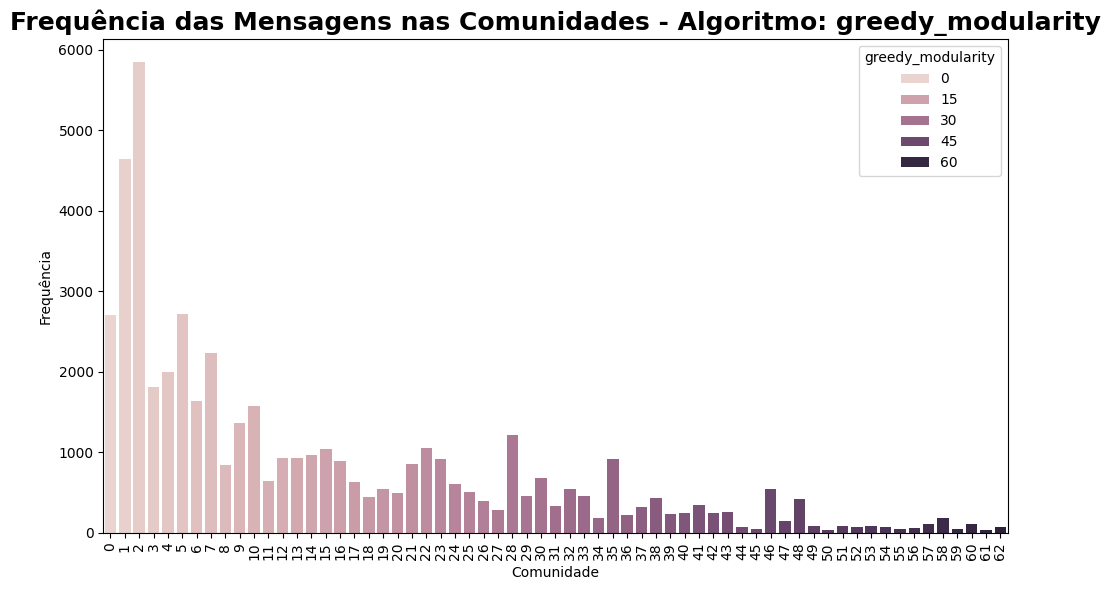

In [54]:
graph_communities_frequency(tweets, 'greedy_modularity')

In [55]:
# Verificando interseção entre usuários da rede social com as comunidades mais postadoras
users_greedy = set(tweets.loc[tweets['greedy_modularity'].isin(tweets['greedy_modularity'].value_counts().nlargest(5).index), 'user'])
intersection = users_greedy.intersection(usuarios_centrais)
print(f'Quantidade de usuários na intersecção: {len(intersection)}')
print('Interseção entre os Centrais do Grafo da Rede Social com os Usuários da Comunidade Lovain:')
print(list(intersection))

Quantidade de usuários na intersecção: 22
Interseção entre os Centrais do Grafo da Rede Social com os Usuários da Comunidade Lovain:
['tommcfly', 'steph_davies', 'Djalfy', 'sophielovemcfly', 'laysxx', 'megpoynter', 'SusanCosmos', 'WalkInTheSun_', '_DINA', 'mharagao', 'JaxLicurse', 'SomersetBob', 'MATT_369', 'jessicastrust', 'esoterismo', 'DavidArchie', 'danipoynterjudd', 'PeaceDiva', 'TheTAZZone', 'mcflyharry', 'faithgoddess7', 'keren4562']


Assim, verificamos que foram encontrados 22 usuários na interseção entre as comunidades com mais mensagens e os usuários centrais da rede social.

Além disso, podemos vislumbrar o grafo da seguinte forma:

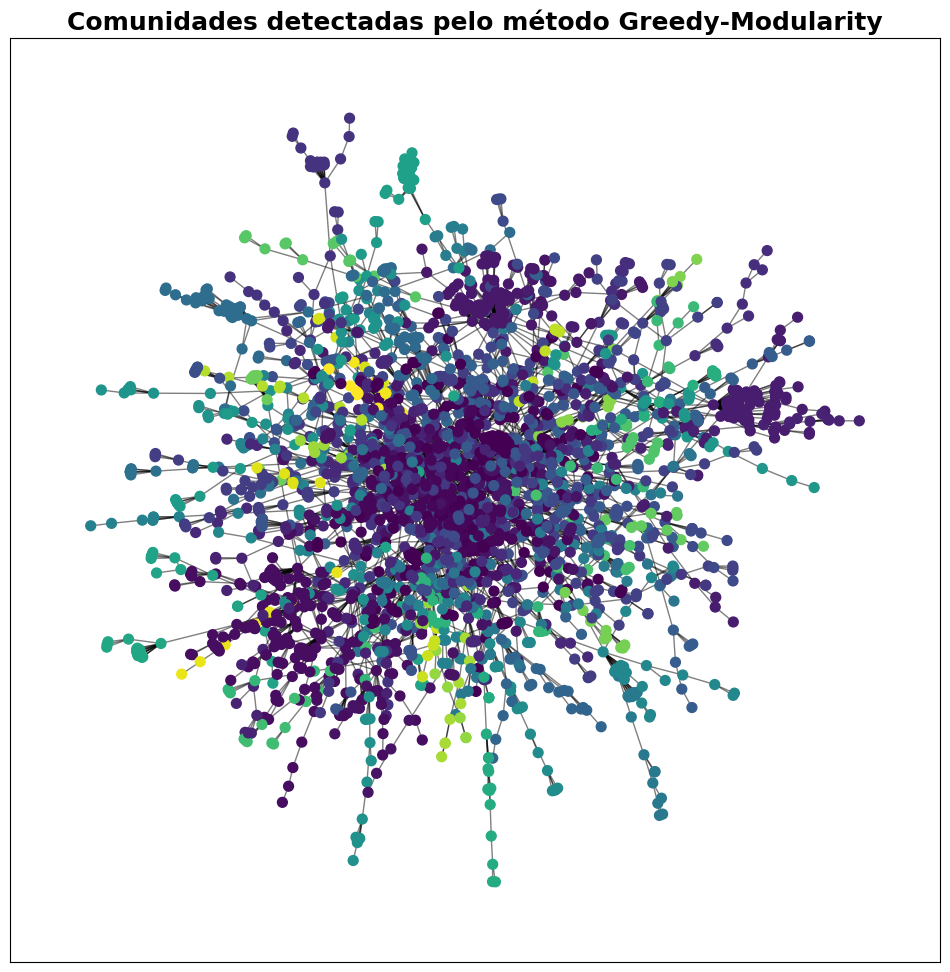

In [56]:
plot_communities(G, greedy_dict, 'Greedy-Modularity')

Os resultados para o algoritmo Greedy-Modularity foram semelhantes aos obtidos pelo método Louvain, indicando consistência na detecção de comunidades dentro da rede analisada. Essa similaridade reforça a robustez e a eficácia desses métodos na identificação das estruturas comunitárias subjacentes.

#### Análise dos Sentimentos em Comunidades

Com o conjunto de dados organizado em um DataFrame, podemos realizar uma análise detalhada dos resultados através da criação de histogramas. Dessa forma, conseguimos visualizar graficamente como os sentimentos estão distribuídos entre algoritmos.

O histograma foi montado considerando dois valores: 
* **Eixo X**: a média dos sentimentos positivos (1) ou negativos (-1) de uma determinadas comunidade, ou seja, realizamos o somatório de todos os valores positivos ou negativos dentro de uma comunidade e dividimos pela quantidade de elementos daquela comunidade. 
* **Eixo Y**: quantidade de vezes que a mesma média foi observada nos cálculos da média. 

Nesse contexto, o histograma irá mostrar as médias calculadas para as comunidades, cujos valores estarão no intervalo [-1,1] e irá variar entre absolutamente negativo (em -1) e o absolutamente positivo (em 1), bem como quantas vezes essas médias apareceram nos cáculos.

In [57]:
# Mapeamento dos resultdos para numérico para aplicação da média para os resultados
tweets['target_num'] = tweets['target'].map({ 'positive': 1, 'negative': -1})

# Criação da coluna média para cada algoritmo e comunidade
communities_types = ['louvain', 'girvan_newman', 'greedy_modularity']

for community_type in communities_types:
    for community in sorted(tweets[community_type].unique()):
        df = tweets[tweets[community_type] == community].copy()
        tweets.loc[tweets[community_type] == community, f'{community_type}_mean'] = df['target_num'].mean()

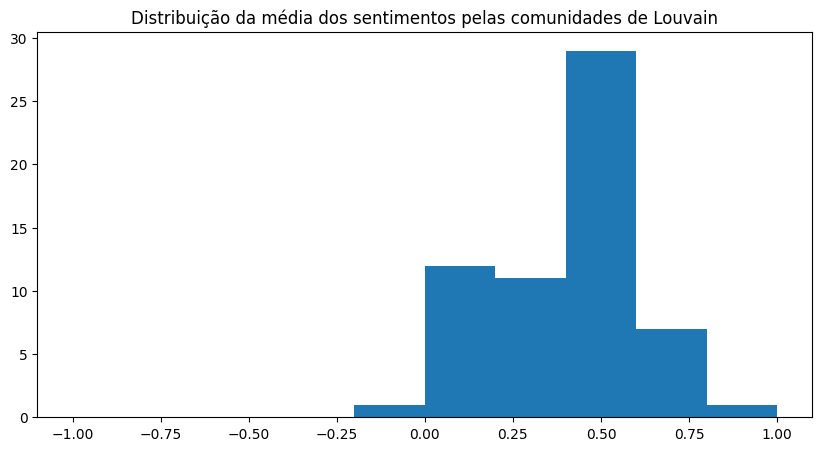

In [58]:
plt.figure(figsize=(10, 5))
plt.hist(tweets.drop_duplicates(subset=['louvain'])['louvain_mean'].tolist(), range=(-1,1))
plt.title('Distribuição da média dos sentimentos pelas comunidades de Louvain')
plt.show()

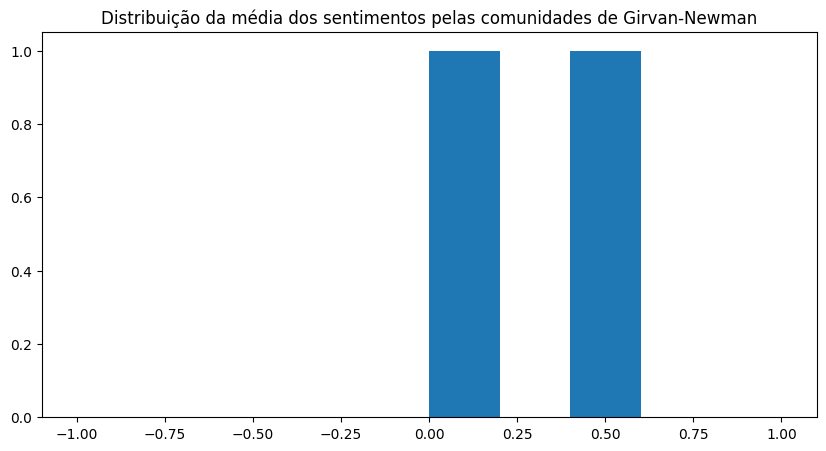

In [59]:
plt.figure(figsize=(10, 5))
plt.hist(tweets.drop_duplicates(subset=['girvan_newman'])['girvan_newman_mean'].tolist(), range=(-1,1))
plt.title('Distribuição da média dos sentimentos pelas comunidades de Girvan-Newman')
plt.show()

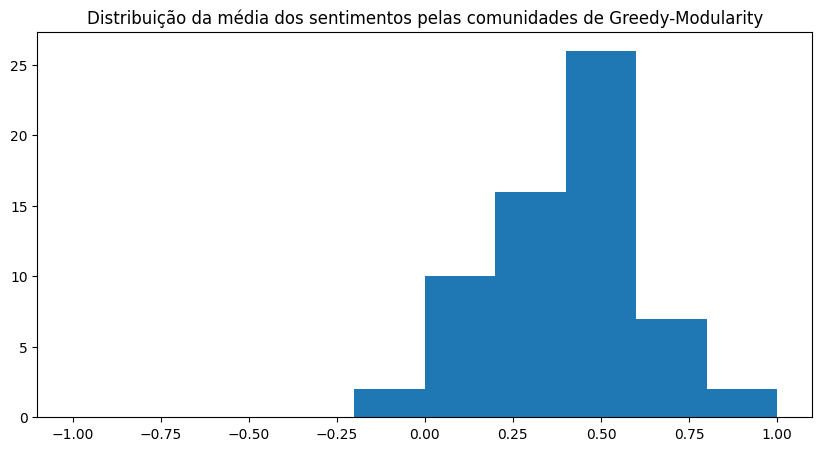

In [60]:
plt.figure(figsize=(10, 5))
plt.hist(tweets.drop_duplicates(subset=['greedy_modularity'])['greedy_modularity_mean'].tolist(), range=(-1,1))
plt.title('Distribuição da média dos sentimentos pelas comunidades de Greedy-Modularity')
plt.show()

A análise dos gráficos revela que os sentimentos positivos predominam em todas as comunidades, evidenciados pelas médias no intervalo [0, 1]. Notavelmente, embora as distribuições dos algoritmos Louvain e Greedy-Modularity sejam semelhantes, o algoritmo Greedy-Modularity apresenta uma média ligeiramente mais positiva.

#### Análise da Nuvem de Palavras

A análise da nuvem de palavras mostra as palavras mais frequentes em cada comunidade, o que nos permite entender melhor o sentimento predominante. Nesse contexto, iremos avaliar a similaridade entre os textos de uma comunidade, por isso iremos retirar uma amostragem aleatória de usuários e realizar uma comparação entre os texto. Deste modo, poderemos avaliar se as comunidades de diferentes algoritmos conservam um mesmo resultado.


##### user: stevegarufi 


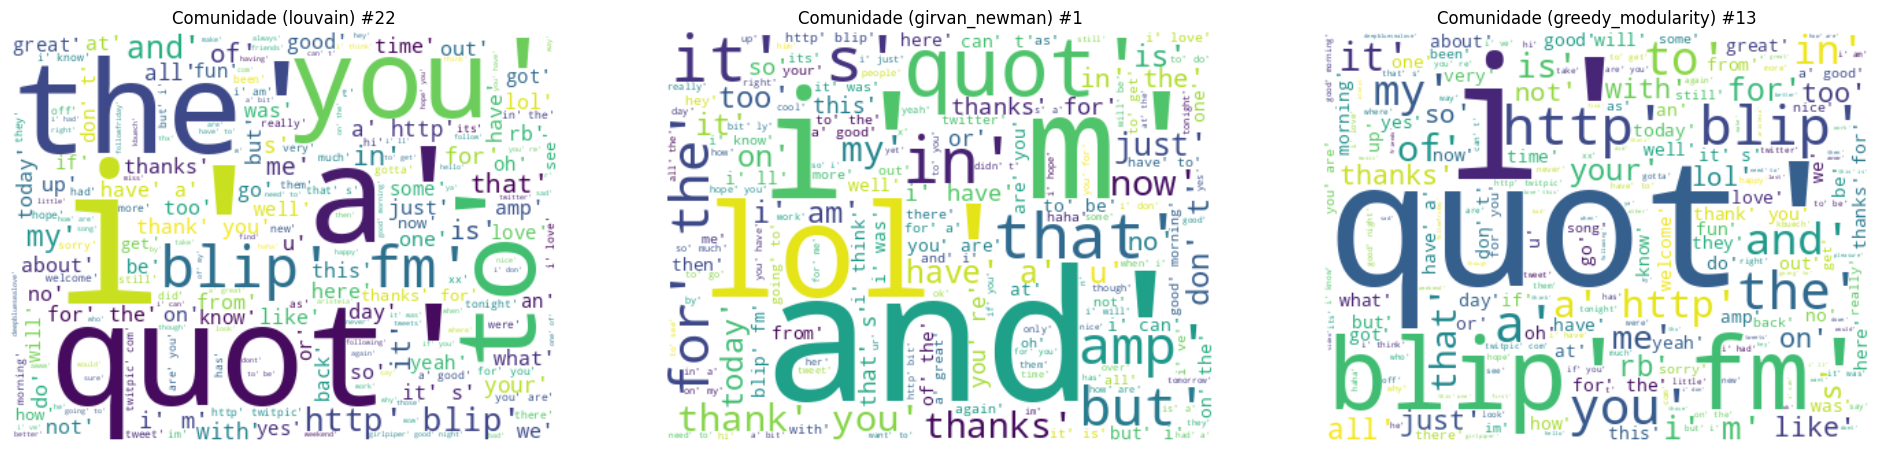

==== SIMILARITY 
girvan_newman vs louvain: 0.9098037337559518
greedy_modularity vs louvain: 0.9889573947520571
greedy_modularity vs girvan_newman: 0.8577884958622277

##### user: brittneymm 


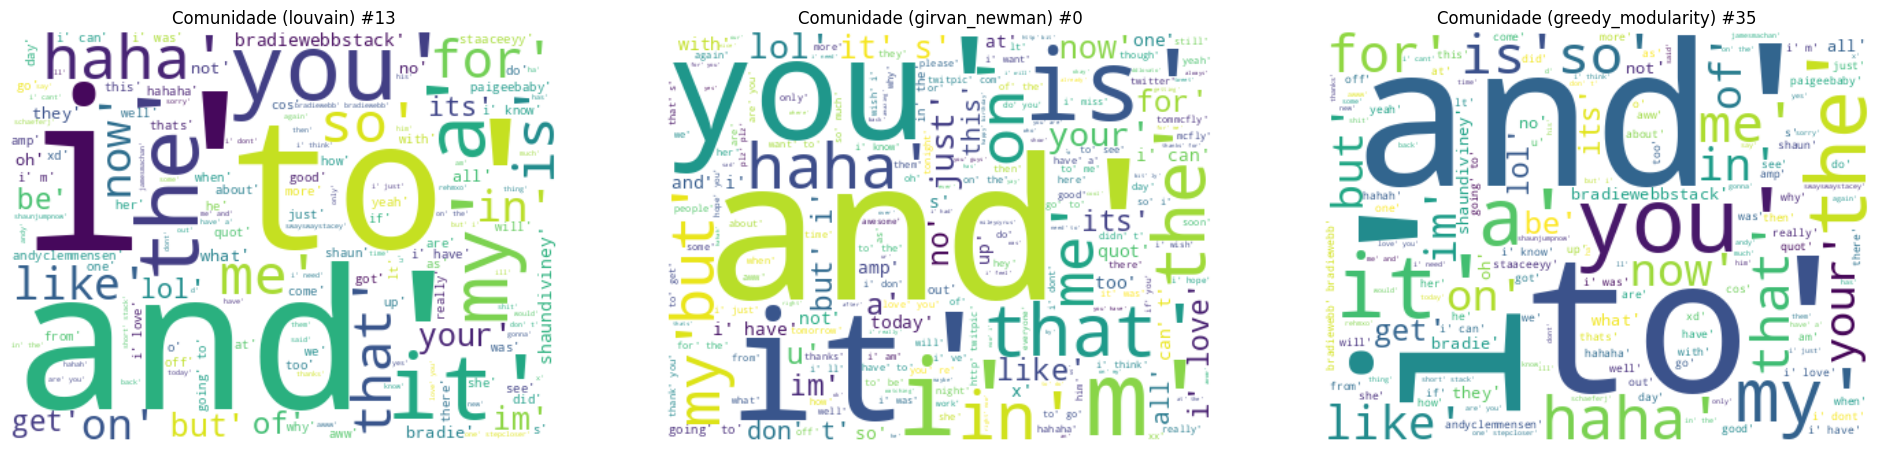

==== SIMILARITY 
girvan_newman vs louvain: 0.9377047195960487
greedy_modularity vs louvain: 1.0000000000000002
greedy_modularity vs girvan_newman: 0.9377047195960487

##### user: DarkPiano 


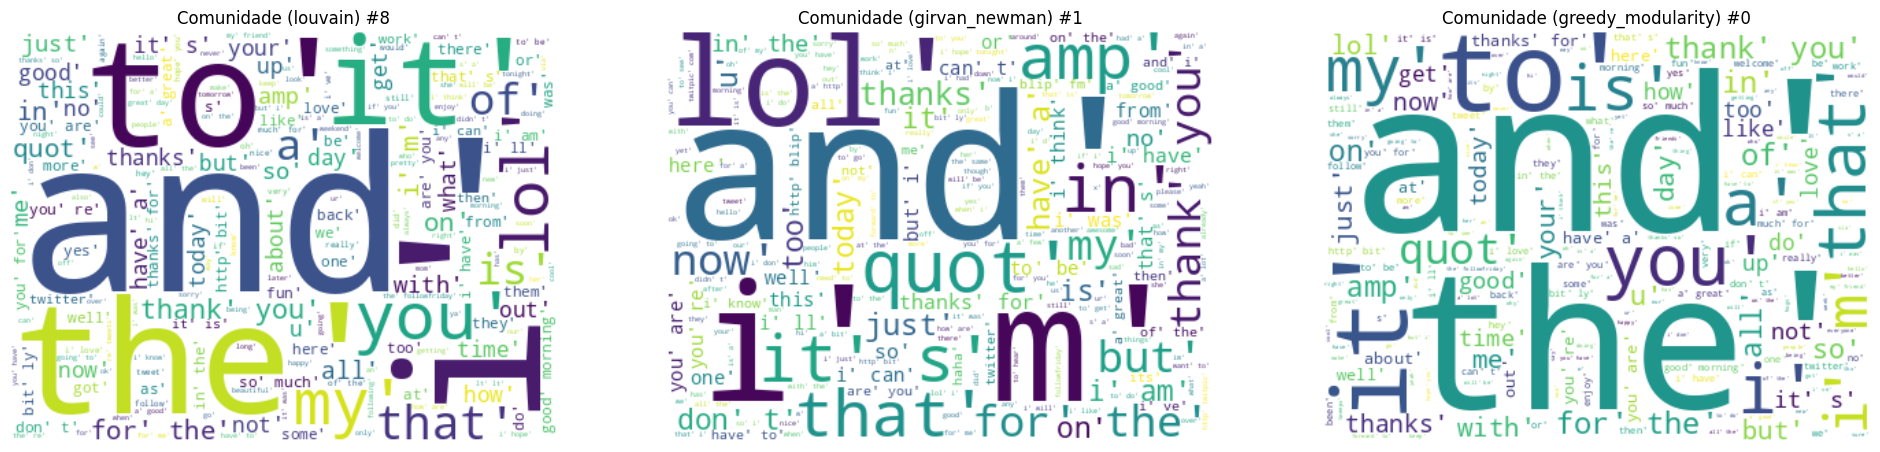

==== SIMILARITY 
girvan_newman vs louvain: 0.9813773116393257
greedy_modularity vs louvain: 0.9950136740690726
greedy_modularity vs girvan_newman: 0.9809829069404561


In [61]:
# Mostragem aleatória de usuários para analise
users = tweets.sample(3)['user'].to_numpy()

for user in users:
    print(f'\n##### user: {user} ')
    cloud_user(tweets, 'preprocessed', user)

Nesse cenário, ao analisarmos os resultados obtidos, observamos que os métodos Greedy-Modularity e Louvain apresentam resultados bastante similares. Isso pode ser atribuído ao número semelhante de comunidades que geram. Por outro lado, o método Girvan-Newman se destaca ao produzir apenas duas comunidades, o que representa uma abordagem bastante distinta em relação aos outros métodos.

#### Nuvens de Palavras Negativas e Positivas Comparadas 

Por fim, iremos analisar as nuvens de palavras destacando as mais positivas e negativas de acordo com o método de modularizar em comunidades uma rede.

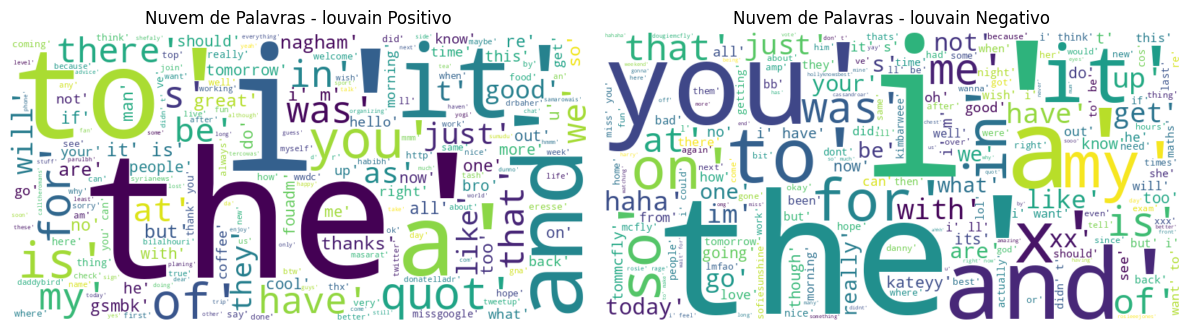

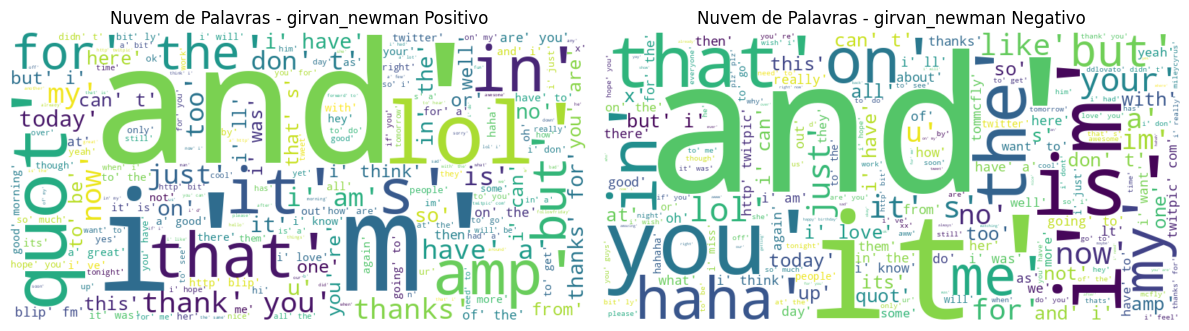

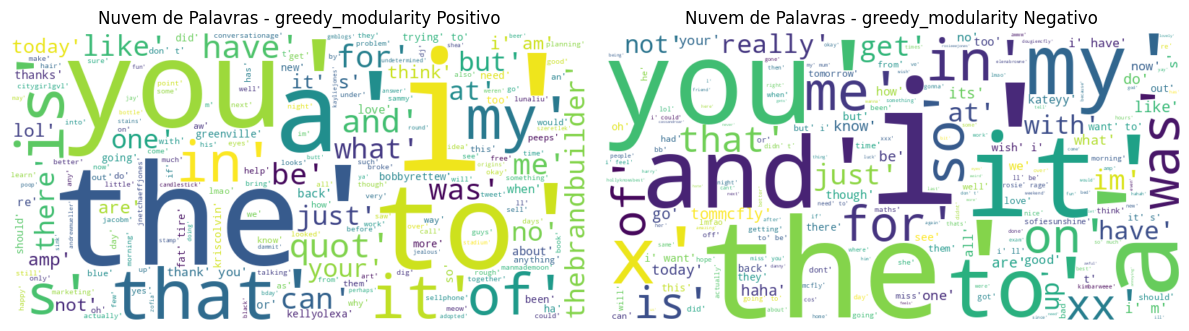

In [62]:
for community in communities_types:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    text_max = ' '.join(tweets[tweets[f'{community}_mean'] == tweets[f'{community}_mean'].max()]['preprocessed'].astype(str))
    text_min = ' '.join(tweets[tweets[f'{community}_mean'] == tweets[f'{community}_mean'].min()]['preprocessed'].astype(str))

    wordcloud_max = WordCloud(width=800, height=400, background_color='white').generate(text_max)
    wordcloud_min = WordCloud(width=800, height=400, background_color='white').generate(text_min)

    ax[0].imshow(wordcloud_max, interpolation='bilinear')
    ax[0].axis('off')
    ax[0].set_title(f'Nuvem de Palavras - {community} Positivo')

    ax[1].imshow(wordcloud_min, interpolation='bilinear')
    ax[1].axis('off')
    ax[1].set_title(f'Nuvem de Palavras - {community} Negativo')

    plt.tight_layout()
    plt.show()

A partir da análise realizada, podemos perceber que as comunidades classificadas como positivas exibem uma predominância de palavras otimistas, como good e like. Além dessas, há também a presença de palavras secundárias de caráter positivo, embora em menor destaque. Este conjunto de palavras contribui para uma atmosfera geral de positividade dentro dessas comunidades.

Por outro lado, as comunidades mais negativas, apesar de apresentarem algumas palavras positivas devido aos valores adquiridos na análise anterior, que indicam que a rede como um todo tende a ser mais positiva, têm um destaque maior de palavras negativas. Termos como bad e miss sobressaem nessas comunidades, evidenciando um contraste significativo em relação às comunidades classificadas como positivas. Este fenômeno ressalta a diversidade de emoções e opiniões presentes nas diferentes comunidades analisadas.

### Resultado Final

Ao final, temos os seguintes dados coletados ao longo de todo o processamento:

In [63]:
tweets

index    target         ids                          date      flag  \
0          169  negative  1467855981  Mon Apr 06 22:31:37 PDT 2009  NO_QUERY   
1          252  negative  1467875208  Mon Apr 06 22:36:39 PDT 2009  NO_QUERY   
2          262  negative  1467878057  Mon Apr 06 22:37:26 PDT 2009  NO_QUERY   
3          328  negative  1467895109  Mon Apr 06 22:42:00 PDT 2009  NO_QUERY   
4          349  negative  1467899451  Mon Apr 06 22:43:12 PDT 2009  NO_QUERY   
...        ...       ...         ...                           ...       ...   
49011  1599809  positive  2193550849  Tue Jun 16 08:36:39 PDT 2009  NO_QUERY   
49012  1599828  positive  2193551571  Tue Jun 16 08:36:42 PDT 2009  NO_QUERY   
49013  1599841  positive  2193552033  Tue Jun 16 08:36:44 PDT 2009  NO_QUERY   
49014  1599847  positive  2193552370  Tue Jun 16 08:36:46 PDT 2009  NO_QUERY   
49015  1599965  positive  2193577918  Tue Jun 16 08:38:53 PDT 2009  NO_QUERY   

                  user                                               text  \
0       Hollywood_Trey  @naughtyhaughty I had on my page for sooooo lo...   
1               realin  Damn i am so late at filling this appraisal fo...   
2      debbieseraphina         help me forget 8th april &amp; 13th july!    
3      IncomeDiscovery  @vene2ia ...not yet unfortunately, another few...   
4            aileen2u2  @Dangerm0use I think maybe you should get a co...   
...                ...                                                ...   
49011          bigenya  @gschan @malditamd @daydreamerping @ragdollgon...   
49012           crside  @dfinchalicious  It ends up like that when goo...   
49013    josephranseth  Good morning everyone! I hope you take some ti...   
49014       omgitsafox              @Common_Pigeon You're quite welcome.    
49015     milliontwits  @stum450n Hi. Thanks for the follow. Nice webs...   

                                            preprocessed  \
0      [, naughtyhaughty, i, had, on, my, page, for, ...   
1      [damn, i, am, so, late, at, filling, this, app...   
2         [help, me, forget, th, april, amp, th, july, ]   
3      [, veneia, not, yet, unfortunately, another, f...   
4      [, dangermuse, i, think, maybe, you, should, g...   
...                                                  ...   
49011  [, gschan, malditamd, daydreamerping, ragdollg...   
49012  [, dfinchalicious, it, ends, up, like, that, w...   
49013  [good, morning, everyone, i, hope, you, take, ...   
49014      [, common, pigeon, you, re, quite, welcome, ]   
49015  [, stumn, hi, thanks, for, the, follow, nice, ...   

                                          Keyword Degree  \
0      [naughtyhaughty, i, had, on, my, page, for, so...   
1      [i, so, am, late, at, filling, this, appraisal...   
2             [th, me, forget, april, amp, july, help, ]   
3      [i, been, , veneia, not, yet, unfortunately, a...   
4      [i, you, , dangermuse, think, maybe, should, g...   
...                                                  ...   
49011  [you, , gschan, malditamd, daydreamerping, rag...   
49012  [, dfinchalicious, it, ends, up, like, that, w...   
49013  [morning, everyone, i, hope, you, take, some, ...   
49014        [, common, pigeon, you, re, quite, welcome]   
49015  [the, website, , stumn, hi, thanks, for, follo...   

                                        Keyword Pagerank  ...  \
0      [naughtyhaughty, in, i, day, had, sad, on, del...  ...   
1      [i, so, work, in, form, people, appraisal, hav...  ...   
2             [th, me, july, forget, april, amp, help, ]  ...   
3      [i, been, , project, veneia, latest, not, my, ...  ...   
4      [you, i, hours, of, more, sleep, couple, hon, ...  ...   
...                                                  ...  ...   
49011  [you, malditamd, gschan, daydreamerping, , rag...  ...   
49012  [, dfinchalicious, it, ends, up, like, that, w...  ...   
49013  [morning, work, starting, to, time, be, some, ...  ...   
49014        [, common, pigeon,

## Conclusão

Após todo o estudo realizado acima, podemos dizer acertadamente que o Projeto Final foi concluído com sucesso, pois conseguimos replicar as técninas expostas nos papers da bibliografia para fazer análise da Rede Social, bem como de suas mensagens. Nesse contexto, realizamos a montagem o grafo da Rede Social Twitter utilizando a comunicação entre os usuários como elemento de conexão entre eles. Em seguida preprocessamos o grafo (excluindo os selfloops e selecionando apenas o maior grafo conectado, bem como utilizamos apenas os usuários que tinha duas ou mais conexões). Identificamos o usuário mais conectado, as métricas da rede e os usuários centrais. Ato contínuo, passamos a analisar as mensagens dos usuários seguindo o seguinte esquema: montamos o grafo da mensagem, calculamos suas métricas, interpretarmos valores quantitativos e semânticos, bem como finalizamos realizando uma análise de sentimento comparativa (utilizando algoritmos clássicos da análise de sentimentos). Por fim, passamos a analisar o sentimento predominante nas comunidades (compartimentando as mensagens em usando os algoritmos de Loucain, Girvan-Newman e Greedy Modularity), momento em que percebemos um perfil de positividade no conteudo. Tudo isso, inclusive, foi corroborado pelas análises das nuvens de palavras e da similaridade entre elas. Portanto, chegamos à seguinte conclusão:

- No caso específico analisado, não foi constatada uma boa formação da rede social para a circulação de informações, sendo certo que, de modo geral, as métricas não apresentaram alta conectividade ou valores que permitissem a conclusão favorecendo o fluxo de informação.
- As mensagens da rede eram formadas por palavras que não se repetiam e tinham uma semântica majoritariamente positiva, indicando que o enunciador se colocava como referência do mundo e direcionava sua mensagem para alguém próximo, normalmente indicando um lugar ou referência de seu gosto.
- A divisão em comunidades apenas segregou as mensagens mais influentes em grupos de pessoas que mais se comunicavam e outros que menos se comunicavam, mas sugeriu que algumas comunidades abrigavam mais usuários centrais que outras.

## BIBLIOGRAFIA

- Amancio, D. A Complex Network Approach to Stylometry. PLoS ONE 10(8): e0136076, 2015. Link: <https://doi.org/10.1371/journal.pone.0136076>

- Amancio, D. Structure-Semantics Interplay in Complex Networks and Its Effects on the Predictability of Similarity in Text. Physica A: Statistical Mechanics and its Applications, Volume 391, Issue 18, 15 September 2012, Pages 4406-4419. Link: <https://www.sciencedirect.com/science/article/pii/S0378437112003044?via%3Dihub>

- Antiqueira, L & Nunes, Maria & Oliveira, Osvaldo & da F. Costa, Luciano. (2005). Modelando Textos como Redes Complexas. 2089-2098. Link: <https://www.researchgate.net/publication/230049093_Modelando_Textos_como_Redes_Complexas>

- Arruda, H., Costa, L.F., Amancio, D.. Using Complex Networks for text Classification: Discriminating Informative and Imaginative Documents. IOPScience, 2016. Link: <https://iopscience.iop.org/article/10.1209/0295-5075/113/28007/meta>

- G. N. Vilarinho and E. E. Seron Ruiz, "Global Centrality Measures in Word Graphs for Twitter Sentiment Analysis," 2018 7th Brazilian Conference on Intelligent Systems (BRACIS), Sao Paulo, Brazil, 2018, pp. 55-60, doi: 10.1109/BRACIS.2018.00018. Link: <https://ieeexplore.ieee.org/document/8575589>

- GO, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12. Link: <https://www.kaggle.com/datasets/kazanova/sentiment140> ou <https://www-cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf>

- Silva, F.N., Amancio, D., Bardosova, M., et alii. Using Network Science and Text Analytics to Produce Surveys in a Scientific Topic. arXiv:1506.05690v2 [cs.SI], 16 Mar 2016. Link: <https://arxiv.org/pdf/1506.05690>